# Next-Year Financial Distress Prediction (Compustat Annual Panel) — Reproducible ML Pipeline

**Goal.** Predict the probability that a firm is in *financial distress* in fiscal year **t+1** using accounting (and permitted market) information available at fiscal year **t**.

**Important scope note.** The outcome is an **engineered distress proxy** (high leverage / balance-sheet stress), not a realized legal default or bankruptcy. The notebook is therefore a **predictive measurement and decision-support pipeline**, not a causal identification design.

---

## Notebook structure (Data Science Lifecycle — 10 phases)

1. Problem Definition & Setup  
2. Data Collection & Panel Integrity  
3. Data Cleaning & Missingness Handling (leakage-aware)  
4. Exploratory Data Analysis (EDA)  
5. Feature Engineering & Target Construction  
6. Preprocessing for Modeling (train-only fitting)  
7. Model Selection & Training (7A Logit; 7B Trees)  
8. Model Evaluation & Diagnostic Monitoring  
9. Decision Support Layer (events, lift, scenarios, cost/decision curves)  
10. Results Summary, Guardrails, and Replication Artifacts

> This organization mirrors the course lifecycle guidance and the project's technical review action items (see provided PDF and technical report).

## How to run (replication package convention)

1. Place `data.csv` in the project root (or update `CONFIG["DATA_PATH"]` in Section 1).
2. Keep `Variables.xlsx` (variable dictionary) alongside the notebook for automatic documentation.
3. Run **Kernel → Restart & Run All**.

The notebook creates an `outputs/` folder containing:
- a predictions export (`predictions.csv`),
- configuration and threshold tables,
- model summary tables suitable for an appendix,
- figures saved as PNG for paper workflow.

## 1. Problem Definition & Setup

### 1.1 Prediction target, success metrics, and decision objective

- **Target (supervised label):** `target_next_v1`, `target_next_v2`, or `target_next_v3` (separate distress proxies). Downstream modeling uses `target_next_v2` by default.  
- **Primary performance metrics (out-of-sample):**
  - ROC-AUC (ranking quality),
  - PR-AUC (class imbalance),
  - Brier score (probability accuracy / calibration).
- **Decision objective (screening):** convert predicted PDs into a review policy using:
  - **misclassification costs** (`COST_FN`, `COST_FP`) and
  - **capacity constraints** (screen top `CAPACITY_PCT` percent of firms).

This is a *risk scoring* workflow: calibrated probabilities and operational interpretability matter more than headline accuracy.

### 1.2 Configuration, determinism, and library versions

In [1]:
# Core numerics
import os
import sys
import math
import json
import warnings
from pathlib import Path
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd

# ML / metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

# Stats / inference
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_cluster, cov_cluster_2groups
from scipy import stats

# Trees / explainability
import xgboost as xgb

import matplotlib.pyplot as plt
from IPython.display import display

warnings.filterwarnings("ignore")

# ----------------------------
# Determinism
# ----------------------------
SEED = 42
np.random.seed(SEED)
USING_SYNTHETIC_DATA = False # Global flag for data mode

# ----------------------------
# Configuration (edit here)
# ----------------------------
CONFIG = {
    # Data inputs
    "DATA_PATH": "data.csv",
    "VARIABLES_XLSX_PATH": "Variables.xlsx",

    # Temporal splitting via label_year = fyear + 1
    "TRAIN_CUTOFF_LABEL_YEAR": 2022,   # label_year <= cutoff -> train/val pool; later -> test
    "VAL_YEARS": 1,                    # number of last label years inside the train pool used as validation

    # Missingness / imputation
    "KNN_K": 25,
    "IMPUTE_LO_Q": 0.01,
    "IMPUTE_HI_Q": 0.99,

    # Preprocessing
    "WINSOR_LO_Q": 0.01,
    "WINSOR_HI_Q": 0.99,

    # Logit hyperparameter search
    "LOGIT_C_GRID": [0.01, 0.1, 1.0, 10.0],

    # Tree model (XGBoost) parameters (conservative / regularized)
    "XGB_PARAMS": {
        "max_depth": 4,
        "min_child_weight": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "eta": 0.05,
        "reg_lambda": 10.0,
        "reg_alpha": 0.0,
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "tree_method": "hist",
        "seed": SEED,
    },
    "XGB_NUM_BOOST_ROUND": 5000,
    "XGB_EARLY_STOPPING": 100,

    # Decision policy parameters (costs + capacity)
    "COST_FN": 10.0,
    "COST_FP": 1.0,
    "CAPACITY_PCT": 0.20,  # screen top 20% by PD as a capacity policy

    # Outputs
    "OUTPUT_DIR": "outputs",
    "FIG_DIR": "figures",
}

Path(CONFIG["OUTPUT_DIR"]).mkdir(parents=True, exist_ok=True)
Path(CONFIG["FIG_DIR"]).mkdir(parents=True, exist_ok=True)

print("CONFIG (key parameters):")
for k in ["DATA_PATH","TRAIN_CUTOFF_LABEL_YEAR","VAL_YEARS","KNN_K","WINSOR_LO_Q","WINSOR_HI_Q","COST_FN","COST_FP","CAPACITY_PCT"]:
    print(f"  {k}: {CONFIG[k]}")
print("\nPython:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

CONFIG (key parameters):
  DATA_PATH: data.csv
  TRAIN_CUTOFF_LABEL_YEAR: 2022
  VAL_YEARS: 1
  KNN_K: 25
  WINSOR_LO_Q: 0.01
  WINSOR_HI_Q: 0.99
  COST_FN: 10.0
  COST_FP: 1.0
  CAPACITY_PCT: 0.2

Python: 3.13.5
pandas: 2.3.1
numpy: 2.2.5


### 1.3 Helper utilities (robust ratios, transforms, and reporting)

In [2]:
def signed_log1p(x: pd.Series) -> pd.Series:
    """Signed log1p transform: sign(x) * log1p(|x|). Preserves zero and sign, stabilizes tails."""
    x = pd.to_numeric(x, errors="coerce")
    return np.sign(x) * np.log1p(np.abs(x))

def safe_divide(numer: pd.Series, denom: pd.Series, denom_floor: float = None) -> pd.Series:
    """Safe divide with optional denominator floor for stability. Returns float with NaN where undefined."""
    numer = pd.to_numeric(numer, errors="coerce")
    denom = pd.to_numeric(denom, errors="coerce")
    if denom_floor is not None:
        denom = denom.where(denom.abs() >= denom_floor, other=np.sign(denom).replace(0, 1) * denom_floor)
    out = numer / denom
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

def ensure_nullable_float(s: pd.Series) -> pd.Series:
    """Convert to pandas nullable Float64 to enable NA-aware comparisons (returns <NA> instead of False)."""
    return pd.to_numeric(s, errors="coerce").astype("Float64")

def winsorize_train_bounds(x: pd.Series, lo: float, hi: float) -> tuple[float, float]:
    """Return winsorization bounds computed on *training* observed values."""
    x = pd.to_numeric(x, errors="coerce")
    x_obs = x.dropna()
    if len(x_obs) == 0:
        return (np.nan, np.nan)
    return (float(x_obs.quantile(lo)), float(x_obs.quantile(hi)))

def apply_bounds(x: pd.Series, lo: float, hi: float) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce")
    if np.isnan(lo) or np.isnan(hi):
        return x
    return x.clip(lower=lo, upper=hi)

def compute_smd(train: pd.Series, test: pd.Series) -> float:
    """Standardized mean difference (SMD): (mu_train - mu_test)/pooled_sd."""
    a = pd.to_numeric(train, errors="coerce").dropna()
    b = pd.to_numeric(test, errors="coerce").dropna()
    if len(a) < 2 or len(b) < 2:
        return np.nan
    mu_a, mu_b = a.mean(), b.mean()
    sd_a, sd_b = a.std(ddof=1), b.std(ddof=1)
    pooled = np.sqrt(0.5*(sd_a**2 + sd_b**2))
    return float((mu_a - mu_b) / pooled) if pooled > 0 else np.nan

def logit(p: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-z))

def print_df(df: pd.DataFrame, n: int = 10, name: str = None):
    if name:
        print(f"\n{name} (top {n} rows):")
    display(df.head(n))

## 2. Data Collection & Panel Integrity

### 2.1 Load variable dictionary (for documentation)

We load the provided variable dictionary (`Variables.xlsx`) to:
- validate required Compustat mnemonics exist in the data file,
- generate appendix-ready variable tables.

This step **does not** transform the modeling data.

In [3]:
vars_path = Path(CONFIG["VARIABLES_XLSX_PATH"])
if vars_path.exists():
    var_dict = pd.read_excel(vars_path, sheet_name=0)
    var_dict.columns = [c.strip() for c in var_dict.columns]
    print(f"Loaded variable dictionary with {len(var_dict)} rows from: {vars_path}")
    display(var_dict.head(90))
else:
    var_dict = pd.DataFrame(columns=["Variable","Two-word Description","Category"])
    print(f"WARNING: variable dictionary not found at {vars_path}. Continuing without it.")

Loaded variable dictionary with 89 rows from: Variables.xlsx


,Variable,Two-word Description,Category
0,aco,Other Current,Balance Sheet
1,act,Current Assets,Balance Sheet
2,ao,Other Assets,Balance Sheet
3,aoloch,Asset/Liability Δ,Cash Flow
4,ap,Accounts Payable,Balance Sheet
...,...,...,...
84,txt,Total Income Taxes,Income Statement
85,xi,Extraordinary Items,Income Statement
86,xido,Extra + Discontinued,Income Statement
87,xidoc,Extraordinary Discontinued Operations,Income Statement


### 2.2 Load raw data (no imputation or transformations)

In [4]:
data_path = Path(CONFIG["DATA_PATH"])
df_raw = pd.read_csv(data_path, low_memory=False)
print(f"Loaded data from {data_path} with shape {df_raw.shape}")

display(df_raw.head())


Loaded data from data.csv with shape (75005, 89)


,gvkey,datadate,fyear,indfmt,datafmt,consol,ismod,conm,aco,act,...,txach,txbcof,txdc,txditc,txp,txt,xi,xido,xidoc,xint
0,1004,2015-05-31,2014,INDL,STD,C,1,AAR CORP,101.6,954.1,...,0.0,0.0,-79.8,104.60,0.00,-28.5,0.0,64.7,-133.7,26.5
1,1019,2014-12-31,2014,INDL,STD,C,1,AFA PROTECTIVE SYSTEMS INC,541.0,23369.0,...,NaN,0.0,-676.0,1635.00,132.00,1058.0,0.0,0.0,0.0,203.0
2,1045,2014-12-31,2014,INDL,STD,C,1,AMERICAN AIRLINES GROUP INC,1260.0,12112.0,...,0.0,0.0,346.0,NaN,0.00,330.0,0.0,0.0,0.0,915.0
3,1050,2014-12-31,2014,INDL,STD,C,1,CECO ENVIRONMENTAL CORP,17424.0,142967.0,...,-1164.0,923.0,-3183.0,26365.00,405.00,3137.0,0.0,0.0,0.0,3138.0
4,1072,2015-03-31,2014,INDL,STD,C,1,AVX CORP,108638.0,1744552.0,...,NaN,474.0,-58387.0,5.77,4.45,-7272.0,0.0,0.0,0.0,978.0


### 2.3 Enforce panel identifiers, types, sorting, and deduplication

In [5]:
df = df_raw.copy()

# Stable firm identifier
if "gvkey" not in df.columns:
    raise ValueError("Required identifier column `gvkey` not found in the dataset.")
df["firm_id"] = df["gvkey"].astype(str)

# Fiscal year
if "fyear" not in df.columns:
    raise ValueError("Required time column `fyear` not found in the dataset.")
df["fyear"] = pd.to_numeric(df["fyear"], errors="coerce").astype("Int64")

# Optional datadate parsing (kept as metadata; not used for splitting)
if "datadate" in df.columns:
    df["datadate"] = pd.to_datetime(df["datadate"], errors="coerce")

# Remove firm-year duplicates (keep-last rule, audit count)
pre_n = len(df)
dup_mask = df.duplicated(subset=["firm_id","fyear"], keep=False)
n_dups = int(dup_mask.sum())
if n_dups > 0:
    print(f"Found {n_dups} duplicated firm-year rows. Applying keep-last rule.")
    df = df.sort_values(["firm_id","fyear","datadate"] if "datadate" in df.columns else ["firm_id","fyear"])
    df = df.drop_duplicates(subset=["firm_id","fyear"], keep="last")
post_n = len(df)

# Enforce sort order for lag/lead safety
df = df.sort_values(["firm_id","fyear"]).reset_index(drop=True)

# Integrity checks
assert df[["firm_id","fyear"]].isna().sum().sum() == 0, "Missing firm_id or fyear after typing."
assert df.duplicated(subset=["firm_id","fyear"]).sum() == 0, "Duplicate firm-year keys remain after dedup."

print(f"Rows: {pre_n:,} -> {post_n:,} after deduplication.")
print("Unique firms:", df["firm_id"].nunique())
print("Year range:", int(df["fyear"].min()), "to", int(df["fyear"].max()))

Rows: 75,005 -> 75,005 after deduplication.
Unique firms: 11403
Year range: 2014 to 2024


### 2.4 Raw sample composition (no transformations)

In [6]:
# Minimal sample composition diagnostics (kept lightweight for large panels)

by_year = df.groupby("fyear").agg(
    n_obs=("firm_id","size"),
    n_firms=("firm_id","nunique"),
).reset_index()

display(by_year.tail(12))

# Optional: industry composition if SIC exists
if "sic" in df.columns:
    df["sic2"] = pd.to_numeric(df["sic"], errors="coerce").astype("Int64") // 100
    by_sic2 = df.groupby("sic2").size().sort_values(ascending=False).head(15).rename("n_obs").reset_index()
    display(by_sic2)
else:
    print("Note: `sic` not present; skipping industry composition.")

,fyear,n_obs,n_firms
0,2014,7455,7455
1,2015,7178,7178
2,2016,6970,6970
3,2017,6831,6831
4,2018,6672,6672
5,2019,6649,6649
6,2020,6703,6703
7,2021,6851,6851
8,2022,6848,6848
9,2023,6611,6611


Note: `sic` not present; skipping industry composition.


## 3. Data Cleaning & Missingness Handling (leakage-aware)

### 3.1 Non-imputable identifiers and label-year setup

We drop observations missing non-imputable identifiers (firm, year).  
We also define `label_year = fyear + 1` as the *outcome year* used for forecasting splits.

In [7]:
# Drop rows with missing key identifiers (already asserted, but keep explicit)
df = df.dropna(subset=["firm_id","fyear"]).copy()

# label_year defines the year of the t+1 distress label
df["label_year"] = (df["fyear"] + 1).astype("Int64")

# Split masks (defined early; used for leakage-safe preprocessing throughout)
train_pool_mask = df["label_year"] <= CONFIG["TRAIN_CUTOFF_LABEL_YEAR"]
train_pool_years = sorted(df.loc[train_pool_mask, "label_year"].dropna().unique().tolist())
if len(train_pool_years) < (CONFIG["VAL_YEARS"] + 1):
    raise ValueError("Not enough label years in train pool to allocate validation years. Adjust TRAIN_CUTOFF_LABEL_YEAR or VAL_YEARS.")

val_years = train_pool_years[-CONFIG["VAL_YEARS"]:]
val_mask = df["label_year"].isin(val_years)
train_mask = train_pool_mask & (~val_mask)
test_mask = df["label_year"] > CONFIG["TRAIN_CUTOFF_LABEL_YEAR"]

df["split"] = np.where(test_mask, "test", np.where(val_mask, "val", "train"))

print("Split counts:")
display(df["split"].value_counts(dropna=False).to_frame("n_obs"))
print("Validation label_year(s):", val_years)

Split counts:


,n_obs
split,
train,48458
test,19696
val,6851


Validation label_year(s): [2022]


### 3.2 Missingness audit before intervention

In [8]:
# Identify numeric columns eligible for imputation (exclude identifiers)
id_cols = {"gvkey","firm_id","fyear","label_year","datadate","split"}
numeric_cols = [c for c in df.columns if c not in id_cols and pd.api.types.is_numeric_dtype(df[c])]

missing_tbl = (df[numeric_cols].isna().mean().sort_values(ascending=False) * 100).rename("missing_%").to_frame()
missing_tbl["n_missing"] = df[numeric_cols].isna().sum().astype(int)
missing_tbl["dtype"] = [str(df[c].dtype) for c in missing_tbl.index]

display(missing_tbl.head(25))

,missing_%,n_missing,dtype
dlcch,44.187721,33143,float64
apalch,40.491967,30371,float64
txach,30.385974,22791,float64
ivstch,25.590294,19194,float64
recch,16.784214,12589,float64
mkvalt,16.465569,12350,float64
sppe,16.317579,12239,float64
act,14.293714,10721,float64
lct,14.259049,10695,float64
xint,14.047064,10536,float64


### 3.3 Create missingness indicators (informative signals)

In [9]:
# Choose a focused set of inputs used for core ratios/events.
REQUIRED_RAW = [
    "at","dlc","dltt","seq","mibt","niadj",
    "oibdp","oancf","xint",
    "act","lct","che","rect","invt",
    # dividend-related (we will auto-detect among these later)
    "dv","dvc","dvt","dvp",
]
available_required = [c for c in REQUIRED_RAW if c in df.columns]

# Hard requirement for the distress proxy; fail if absent (unless synthetic mode)
HARD_REQUIRED = ["at","dlc","dltt","seq","oibdp","niadj","oancf"]
missing_hard = [c for c in HARD_REQUIRED if c not in df.columns]
if missing_hard and not USING_SYNTHETIC_DATA:
    raise ValueError(f"Missing required columns for distress proxy construction: {missing_hard}")

for c in available_required:
    df[f"fmiss_{c}"] = df[c].isna().astype("Int8")

print("Created missingness flags for:", available_required)

Created missingness flags for: ['at', 'dlc', 'dltt', 'seq', 'mibt', 'niadj', 'oibdp', 'oancf', 'xint', 'act', 'lct', 'che', 'rect', 'invt', 'dv', 'dvc', 'dvt', 'dvp']


### 3.4 Training-derived size deciles (used for peer imputation groups)

In [10]:
# Size is based on log(assets) from TRAIN only, to avoid leakage.
at_train = pd.to_numeric(df.loc[train_mask, "at"], errors="coerce")
log_at_train = np.log(at_train.where(at_train > 0)).dropna()

if len(log_at_train) < 50:
    print("WARNING: too few non-missing training `at` values for stable size deciles. Using a single size bin.")
    df["size_decile"] = 5  # arbitrary mid-bin
    size_edges = None
else:
    # Use quantile cutpoints computed on training only
    qs = np.linspace(0, 1, 11)
    size_edges = log_at_train.quantile(qs).values
    size_edges[0] = -np.inf
    size_edges[-1] = np.inf

    log_at_all = np.log(pd.to_numeric(df["at"], errors="coerce").where(lambda s: s > 0))
    df["size_decile"] = pd.cut(log_at_all, bins=size_edges, labels=False, include_lowest=True).astype("Float64")

# Fill NA size_decile with training median decile for downstream stability
sd_med = float(pd.to_numeric(df.loc[train_mask, "size_decile"], errors="coerce").median())
df["size_decile"] = pd.to_numeric(df["size_decile"], errors="coerce").fillna(sd_med).astype(int)

print("Size decile distribution (train):")
display(df.loc[train_mask, "size_decile"].value_counts().sort_index().to_frame("n_obs"))

Size decile distribution (train):


,n_obs
size_decile,
0,4824
1,4823
2,4824
3,4823
4,5047
5,4823
6,4823
7,4824
8,4823


### 3.5 Imputation Pipeline

In [11]:
# Snapshot before any imputation
df_pre_impute_snapshot = df.copy(deep=True)

### 3.5.1 KNN imputation on core structural items (train-fit; signed-log transform)

We use KNN for core balance sheet and income statement aggregates. These variables have strong multivariate dependencies (e.g., Total Assets ≈ Total Liabilities + Equity). KNN captures these relationships, allowing the imputation to respect the specific "profile" of a company.

In [12]:
# Core structural variables for KNN
knn_cols = [
    "at", "act", "lct", "che", "rect", "invt", "dlc", "dltt", 
    "seq", "ceq", "lt", "ppent", "intan", "oibdp", "niadj", 
    "oancf", "xint", "dp", "re", "capx"
]
knn_cols = [c for c in knn_cols if c in df.columns]

if len(knn_cols) >= 3:
    Z = df[knn_cols + ["fyear","size_decile"]].copy()
    # Transform magnitudes for distance stability
    for c in knn_cols:
        Z[c] = signed_log1p(Z[c])
    # Keep fyear/size_decile in levels
    Z["fyear"] = pd.to_numeric(Z["fyear"], errors="coerce")
    Z["size_decile"] = pd.to_numeric(Z["size_decile"], errors="coerce")

    # --- KNN Imputation using training data ---
    imputer = KNNImputer(n_neighbors=CONFIG["KNN_K"], weights="distance")
    imputer.fit(Z.loc[train_mask, :])

    Z_imp = pd.DataFrame(imputer.transform(Z), columns=Z.columns, index=Z.index)

    # Invert signed-log transform back for magnitudes
    for c in knn_cols:
        # inverse of signed_log1p: sign(z)*(exp(|z|)-1)
        z = pd.to_numeric(Z_imp[c], errors="coerce")
        df[c] = np.sign(z) * (np.expm1(np.abs(z)))
else:
    print("Skipping KNN imputation: insufficient columns available.")

### 3.5.2 KNN Parameter Selection Audit

We evaluate the reconstruction quality for different values of $K$ to justify the choice of `KNN_K=25`. We use a subset of fully observed training data and artificially introduce missingness to measure RMSE.

In [13]:
from sklearn.metrics import mean_squared_error

def evaluate_knn_k(Z_train, k_list, mask_fraction=0.1, seed=42):
    # Subset to fully observed rows for ground truth
    ground_truth_full = Z_train.dropna()
    if len(ground_truth_full) < 100:
        return None
    
    # Sample if too large for speed
    if len(ground_truth_full) > 2000:
        ground_truth = ground_truth_full.sample(n=2000, random_state=seed)
    else:
        ground_truth = ground_truth_full
        
    # Create masked version
    rng = np.random.default_rng(seed)
    masked_data = ground_truth.copy()
    
    # Only mask the core numeric columns (knn_cols)
    cols_to_mask = [c for c in ground_truth.columns if c not in ["fyear", "size_decile"]]
    
    for col in cols_to_mask:
        mask = rng.random(len(masked_data)) < mask_fraction
        masked_data.loc[mask, col] = np.nan
        
    results = []
    for k in k_list:
        imputer_test = KNNImputer(n_neighbors=k, weights="distance")
        # Fit on the original (possibly missing) training data
        imputer_test.fit(Z_train) 
        # Transform the artificially masked data
        imputed_data = imputer_test.transform(masked_data)
        imputed_df = pd.DataFrame(imputed_data, columns=ground_truth.columns, index=ground_truth.index)
        
        # Calculate RMSE only on the values we masked
        mse = 0
        count = 0
        for col in cols_to_mask:
            actual_mask = masked_data[col].isna()
            if actual_mask.any():
                mse += mean_squared_error(ground_truth.loc[actual_mask, col], imputed_df.loc[actual_mask, col]) * actual_mask.sum()
                count += actual_mask.sum()
        
        rmse = np.sqrt(mse / count) if count > 0 else np.nan
        results.append({"K": k, "RMSE": rmse})
        
    return pd.DataFrame(results)

if 'knn_cols' in locals() and len(knn_cols) >= 3:
    print("Evaluating KNN imputation performance (reconstruction RMSE)...")
    k_options = [5, 10, 25, 50, 100]
    knn_audit_df = evaluate_knn_k(Z.loc[train_mask, :], k_options)
    
    if knn_audit_df is not None:
        display(knn_audit_df.style.highlight_min(subset="RMSE", color="lightgreen"))
        
        k25_rmse = knn_audit_df.loc[knn_audit_df["K"] == 25, "RMSE"].values[0]
        best_k = knn_audit_df.loc[knn_audit_df["RMSE"].idxmin(), "K"]
        print(f"\nKNN K=25 RMSE: {k25_rmse:.4f}")
        if best_k == 25:
            print("K=25 is the optimal parameter among tested values.")
        else:
            print(f"Optimal K among tested is {best_k}. K=25 is used as a balanced choice.")
    else:
        print("Insufficient fully observed data for KNN audit.")

Evaluating KNN imputation performance (reconstruction RMSE)...


,K,RMSE
0,5,0.000031
1,10,0.000059
2,25,0.000133
3,50,0.000249
4,100,0.000458



KNN K=25 RMSE: 0.0001
Optimal K among tested is 5. K=25 is used as a balanced choice.


### 3.6 Train-only peer-median imputation (fyear × size_decile)

We use year-size median imputation for secondary items, "other" categories, and sparse flow variables (e.g., dividends, acquisitions). These variables are often missing, zero, or highly idiosyncratic. Using a multivariate model like KNN on them might introduce noise or over-impute non-zero values for sparse events. A year-size median provides a robust "typical" value for companies of similar scale in the same year, which is a safer conservative estimate for these items.

In [14]:
# Secondary/incidental variables for Peer Median
peer_impute_candidates = [
    "aco", "lco", "recch", "invch", "txp", "txditc", 
    "caps", "mibt", "aqc", "prstkc",
    "dv", "dvc", "dvt", "dvp"
]
peer_impute_cols = [c for c in peer_impute_candidates if c in df.columns]

group_cols = ["fyear","size_decile"]

def peer_median_impute(df_in: pd.DataFrame, cols: list[str], train_mask: pd.Series, group_cols: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Impute NaNs using TRAIN-only medians by group_cols, with TRAIN (size_decile) then global median fallback."""
    df_out = df_in.copy()
    train = df_out.loc[train_mask, group_cols + cols].copy()
    group_meds = train.groupby(group_cols)[cols].median()
    global_meds = train[cols].median()

    # Intermediate fallback for unseen (fyear, size_decile): use TRAIN size_decile medians
    size_meds = train.groupby(["size_decile"])[cols].median()
    tmp_size = df_out[["size_decile"]].merge(size_meds.reset_index(), on="size_decile", how="left")

    # Join group medians (wide) to all rows
    tmp = df_out[group_cols].merge(group_meds.reset_index(), on=group_cols, how="left", suffixes=("", "_peer"))
    # tmp currently contains the group median columns with original names
    for c in cols:
        peer_med = tmp[c]
        df_out[c] = df_out[c].where(df_out[c].notna(), peer_med)
        size_med = tmp_size[c]
        df_out[c] = df_out[c].where(df_out[c].notna(), size_med)
        df_out[c] = df_out[c].where(df_out[c].notna(), global_meds[c])
    impact = pd.DataFrame({
        "col": cols,
        "n_imputed": [int(df_in[c].isna().sum() - df_out[c].isna().sum()) for c in cols],
        "train_global_median": [float(global_meds[c]) if pd.notna(global_meds[c]) else np.nan for c in cols],
    })
    return df_out, impact

df, peer_impact = peer_median_impute(df, peer_impute_cols, train_mask, group_cols)

display(peer_impact.sort_values("n_imputed", ascending=False).head(15))

,col,n_imputed,train_global_median
2,recch,12589,-11.0
5,txditc,9069,0.0
4,txp,7942,0.0
1,lco,6779,3415.5
0,aco,6778,766.0
3,invch,5315,0.0
9,prstkc,3410,0.0
6,caps,3074,21944.0
8,aqc,2812,0.0
10,dv,1137,0.0


### 3.7 Guardrail capping of imputed magnitudes (train quantile bands)

In [15]:
# Apply capping to all columns that underwent imputation (KNN and Peer Median)
cap_cols = list(set(knn_cols + peer_impute_cols))
bounds = {}

for c in cap_cols:
    lo, hi = winsorize_train_bounds(df_pre_impute_snapshot.loc[train_mask, c], CONFIG["IMPUTE_LO_Q"], CONFIG["IMPUTE_HI_Q"])
    bounds[c] = {"lo": lo, "hi": hi}
    df[c] = apply_bounds(df[c], lo, hi)

bounds_df = pd.DataFrame({c: (v["lo"], v["hi"]) for c,v in bounds.items()}, index=["lo","hi"]).T
bounds_df.index.name = "col"
display(bounds_df.head(15))

,lo,hi
col,,
at,0.93,50746128.37
rect,0.00,16780556.04
oibdp,-157336.02,4359988.88
seq,-155487.96,14903048.78
oancf,-136407.56,3365799.80
lt,1.00,40276299.60
txditc,0.00,833087.35
aqc,-22209.00,589041.50
prstkc,0.00,508786.45


### 3.8 Imputation impact audit (pre vs post)

In [16]:
audit_cols = [c for c in ["at","dlc","dltt","seq","oibdp","oancf","act","lct"] if c in df.columns]

def dist_summary(x: pd.Series) -> dict:
    x = pd.to_numeric(x, errors="coerce")
    return {
        "n": int(x.notna().sum()),
        "mean": float(x.mean()) if x.notna().any() else np.nan,
        "p50": float(x.median()) if x.notna().any() else np.nan,
        "p10": float(x.quantile(0.10)) if x.notna().any() else np.nan,
        "p90": float(x.quantile(0.90)) if x.notna().any() else np.nan,
    }

rows = []
for c in audit_cols:
    pre = dist_summary(df_pre_impute_snapshot[c])
    post = dist_summary(df[c])
    rows.append({
        "col": c,
        "n_pre": pre["n"],
        "n_post": post["n"],
        "mean_pre": pre["mean"],
        "mean_post": post["mean"],
        "p50_pre": pre["p50"],
        "p50_post": post["p50"],
    })
impact_tbl = pd.DataFrame(rows).sort_values("col")
display(impact_tbl)

,col,n_pre,n_post,mean_pre,mean_post,p50_pre,p50_post
6,act,64284,75005,6.440956e+05,4.211415e+05,23074.0,32222.000000
0,at,75005,75005,5.597314e+06,2.060420e+06,96379.0,96379.000000
1,dlc,74974,75005,3.666371e+05,8.782179e+04,588.0,589.000000
2,dltt,74817,75005,9.226323e+05,4.592569e+05,3416.0,3375.000000
7,lct,64310,75005,4.755088e+05,2.891418e+05,11405.0,16148.115846
5,oancf,74702,75005,1.976674e+05,1.198117e+05,644.0,638.000000
4,oibdp,72863,75005,2.472644e+05,1.488102e+05,800.4,919.000000
3,seq,75002,75005,9.623007e+05,6.320878e+05,34787.5,34784.000000


## 4. Exploratory Data Analysis (EDA)

EDA focuses on **signal strength and data quality**, not exhaustive plotting.  
At this stage we describe the imputed-but-not-modeled input space, by split.

### 4.1 Summary statistics by split (key magnitudes)

In [17]:
eda_cols = [c for c in ["at","dlc","dltt","seq","oibdp","oancf","xint"] if c in df.columns]

def split_describe(df_in: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    out = []
    for sp in ["train","val","test"]:
        d = df_in.loc[df_in["split"]==sp, cols].describe(percentiles=[0.01,0.1,0.5,0.9,0.99]).T
        d.insert(0, "split", sp)
        d.insert(1, "col", d.index)
        out.append(d.reset_index(drop=True))
    return pd.concat(out, ignore_index=True)

desc_tbl = split_describe(df, eda_cols)
display(desc_tbl.head(20))

,split,col,count,mean,std,min,1%,10%,50%,90%,99%,max
0,train,at,48458.0,1.958101e+06,6.596407e+06,0.93,0.9300,534.985,90113.000000,3790678.7,5.067805e+07,50746128.37
1,train,dlc,48458.0,8.545425e+04,3.917404e+05,0.00,0.0000,0.000,304.000000,92466.8,3.229014e+06,3229014.45
2,train,dltt,48458.0,4.453629e+05,1.581456e+06,0.00,0.0000,0.000,2144.800000,920105.2,1.178757e+07,11798057.82
3,train,seq,48458.0,5.974389e+05,1.953980e+06,-155487.96,-155258.2728,-383.790,33092.500000,1252878.4,1.487620e+07,14903048.78
4,train,oibdp,48458.0,1.417991e+05,5.547976e+05,-157336.02,-152927.2400,-12177.500,1096.500000,272939.8,4.223344e+06,4359988.88
5,train,oancf,48458.0,1.157469e+05,4.347614e+05,-136407.56,-135978.6000,-10121.600,779.750000,239939.4,3.324934e+06,3365799.80
6,train,xint,48458.0,2.039505e+04,6.336385e+04,0.00,0.0000,0.000,446.191766,49721.6,4.220044e+05,464656.90
7,val,at,6851.0,2.165063e+06,6.845755e+06,0.93,1.0000,918.000,125582.000000,4515726.0,5.049778e+07,50746128.37
8,val,dlc,6851.0,8.538966e+04,3.905131e+05,0.00,0.0000,0.000,1027.000000,90986.0,3.164053e+06,3229014.45
9,val,dltt,6851.0,4.992185e+05,1.690081e+06,0.00,0.0000,0.000,6117.000000,1073364.0,1.179806e+07,11798057.82


### 4.2 Missingness rates by split (key inputs)

In [18]:
miss_cols = [c for c in available_required if f"fmiss_{c}" in df.columns]
miss_by_split = (
    df.groupby("split")[ [f"fmiss_{c}" for c in available_required if f"fmiss_{c}" in df.columns] ]
      .mean()
      .T
)
miss_by_split.index = [i.replace("fmiss_","") for i in miss_by_split.index]
miss_by_split = (miss_by_split * 100).round(2)
display(miss_by_split)

split,test,train,val
at,0.0,0.0,0.0
dlc,0.03,0.05,0.03
dltt,0.16,0.29,0.23
seq,0.0,0.01,0.0
mibt,0.76,1.3,0.89
niadj,0.0,0.0,0.0
oibdp,2.65,2.94,2.89
oancf,0.28,0.46,0.35
xint,14.57,13.92,13.43
act,13.62,14.66,13.66


### 4.3 Visual sanity-check plots (train vs test distributions)

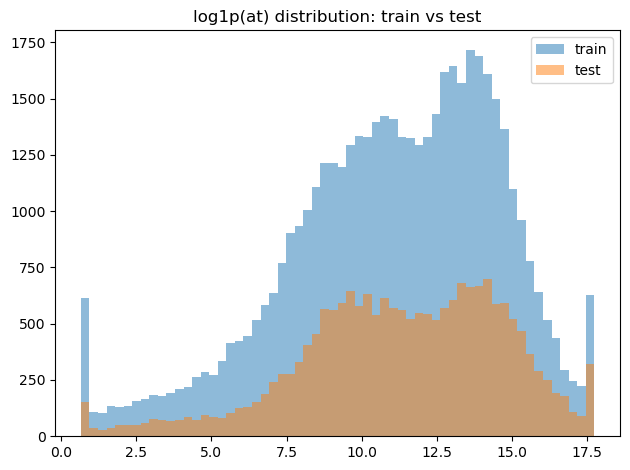

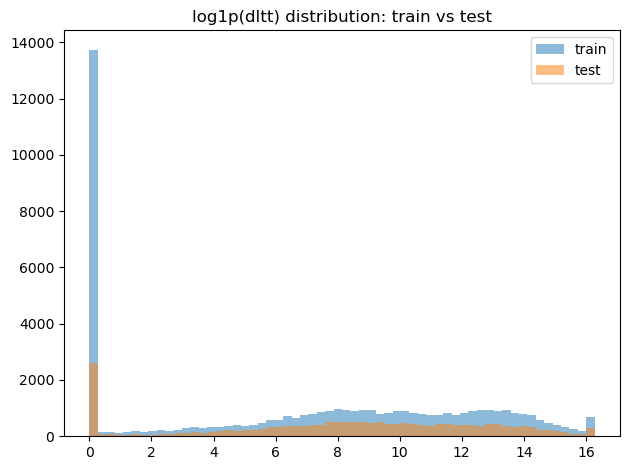

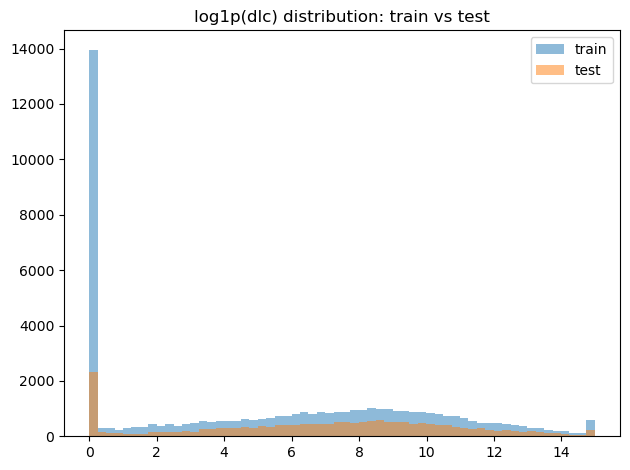

In [19]:
# Lightweight plots to spot gross drift / outliers.
plot_cols = [c for c in ["at","dltt","dlc","oibdp","oancf"] if c in df.columns]

for c in plot_cols[:3]:
    a = pd.to_numeric(df.loc[df["split"]=="train", c], errors="coerce")
    b = pd.to_numeric(df.loc[df["split"]=="test", c], errors="coerce")
    plt.figure()
    plt.hist(np.log1p(a.dropna()), bins=60, alpha=0.5, label="train")
    plt.hist(np.log1p(b.dropna()), bins=60, alpha=0.5, label="test")
    plt.title(f"log1p({c}) distribution: train vs test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path(CONFIG["FIG_DIR"]) / f"eda_log1p_{c}_train_vs_test.png", dpi=140)
    plt.show()

## 5. Feature Engineering & Target Construction

This section constructs **all derived features explicitly** from Compustat-style raw items, including:
- debt aggregates and leverage ratios,
- cash-flow-to-debt ratios,
- log size and log market value,
- the NA-aware distress proxy and the next-year label.

Design choice: ratios with non-positive denominators are treated as **extreme tail states** (encoded via `+∞` then converted to `NaN` before modeling), rather than silently set to zero.

### 5.1 Feature list definitions (V1, V2, V3)

In [20]:
FEATURES_V1 = [
    "ln_at", "cash_at", "current_ratio", "nwc_at", "aco_act", 
    "lco_lct", "rect_act", "invt_act", "recch_act", "invch_act", 
    "txp_lct", "txditc_at", "lt_at", "dlc_at", "dltt_at", 
    "debt_at", "st_debt_share", "ebitda_at", "ebit_at", "dp_at", 
    "xint_at", "interest_coverage", "debt_to_ebitda", "ebit_to_capital", "capx_at"
]

FEATURES_V2 = [
    "ln_at", "cash_at", "current_ratio", "nwc_at", "aco_act", 
    "lco_lct", "rect_act", "invt_act", "ppent_at", "intan_at", 
    "txp_lct", "txditc_at", "lt_at", "debt_at", "st_debt_share", 
    "ebitda_at", "ebit_at", "xint_at", "interest_coverage", "debt_to_ebitda", 
    "ebit_to_capital", "ocf_to_debt", "fcf_to_debt", "capx_at", "re_at"
]

FEATURES_V3 = [
    "ln_at", "cash_at", "current_ratio", "nwc_at", "aco_act", 
    "lco_lct", "rect_act", "invt_act", "recch_act", "invch_act", 
    "txp_lct", "txditc_at", "lt_at", "ceq_at", "re_at", 
    "caps_at", "mibt_at", "dp_at", "niadj_at", "loss_indicator", 
    "xint_at", "xint_lct", "capx_at", "aqc_at", "prstkc_at"
]

### 5.2 Debt, capital, and operating aggregates

In [21]:
# Ensure all required raw items are numeric for safe arithmetic
raw_items = [
    "at", "che", "act", "lct", "aco", "lco", "rect", "invt", "recch", "invch",
    "txp", "txditc", "lt", "dlc", "dltt", "oibdp", "dp", "xint", "ceq", "capx",
    "ppent", "intan", "oancf", "re", "caps", "mibt", "niadj", "aqc", "prstkc", "seq"
]
for c in raw_items:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Debt aggregate
df["total_debt"] = df[["dlc","dltt"]].sum(axis=1, min_count=1)

# Equity plus minority interest (if available)
if "mibt" in df.columns:
    df["equity_plus_mi"] = df[["seq","mibt"]].sum(axis=1, min_count=1)
else:
    df["equity_plus_mi"] = df["seq"]

# Total capital and a non-positive capital flag
df["total_capital"] = df[["total_debt","equity_plus_mi"]].sum(axis=1, min_count=1)
df["cap_nonpos_flag"] = (df["total_capital"] <= 0).astype("Int8")

# EBITDA proxy
df["ebitda_proxy"] = df["oibdp"]
df["ebitda_nonpos_flag"] = (df["ebitda_proxy"] <= 0).astype("Int8")

# Log transforms
df["ln_at"] = np.log(df["at"].where(lambda s: s > 0))
# Legacy name if needed elsewhere
df["log_at"] = df["ln_at"]


### 5.3 Leverage, coverage, and cash-flow ratios (V1, V2, V3 features)

In [22]:
# --- V1/V2/V3 Shared & Specific Features ---
# (Using safe_divide which handles division by zero and returns NaN for extreme states)

# Basic Ratios
df["cash_at"] = safe_divide(df["che"], df["at"])
df["current_ratio"] = safe_divide(df["act"], df["lct"])
df["nwc_at"] = safe_divide(df["act"] - df["lct"], df["at"])
df["aco_act"] = safe_divide(df["aco"], df["act"])
df["lco_lct"] = safe_divide(df["lco"], df["lct"])
df["rect_act"] = safe_divide(df["rect"], df["act"])
df["invt_act"] = safe_divide(df["invt"], df["act"])
df["recch_act"] = safe_divide(df["recch"], df["act"])
df["invch_act"] = safe_divide(df["invch"], df["act"])
df["txp_lct"] = safe_divide(df["txp"], df["lct"])
df["txditc_at"] = safe_divide(df["txditc"], df["at"])
df["lt_at"] = safe_divide(df["lt"], df["at"])
df["dlc_at"] = safe_divide(df["dlc"], df["at"])
df["dltt_at"] = safe_divide(df["dltt"], df["at"])
df["debt_at"] = safe_divide(df["total_debt"], df["at"])
df["st_debt_share"] = safe_divide(df["dlc"], df["total_debt"])
df["ebitda_at"] = safe_divide(df["oibdp"], df["at"])
df["ebit_at"] = safe_divide(df["oibdp"] - df["dp"], df["at"])
df["dp_at"] = safe_divide(df["dp"], df["at"])
df["xint_at"] = safe_divide(df["xint"], df["at"])
df["interest_coverage"] = safe_divide(df["oibdp"], df["xint"])
df["debt_to_ebitda"] = safe_divide(df["total_debt"], df["oibdp"])
df["ebit_to_capital"] = safe_divide(df["oibdp"] - df["dp"], df["total_debt"] + df["ceq"])
df["capx_at"] = safe_divide(df["capx"], df["at"])

# V2 extras
df["ppent_at"] = safe_divide(df["ppent"], df["at"])
df["intan_at"] = safe_divide(df["intan"], df["at"])
df["ocf_to_debt"] = safe_divide(df["oancf"], df["total_debt"])
df["fcf_to_debt"] = safe_divide(df["oancf"] - df["capx"], df["total_debt"])
df["re_at"] = safe_divide(df["re"], df["at"])

# V3 extras
df["ceq_at"] = safe_divide(df["ceq"], df["at"])
df["caps_at"] = safe_divide(df["caps"], df["at"])
df["mibt_at"] = safe_divide(df["mibt"], df["at"])
df["niadj_at"] = safe_divide(df["niadj"], df["at"])
df["loss_indicator"] = (df["niadj"] < 0).astype(float)
df["xint_lct"] = safe_divide(df["xint"], df["lct"])
df["aqc_at"] = safe_divide(df["aqc"], df["at"])
df["prstkc_at"] = safe_divide(df["prstkc"], df["at"])

# --- Legacy mappings for distress proxy definitions (Section 5.4) ---
# (Keeping sp_ prefix for variables used in distress proxy definition rules)
ffo_proxy = df["oancf"] + df["xint"]
if "txp" in df.columns:
    ffo_proxy = ffo_proxy - df["txp"]
df["sp_ffo_to_debt"] = safe_divide(ffo_proxy, df["total_debt"])
df["sp_debt_to_capital"] = safe_divide(df["total_debt"], df["total_capital"])
df["sp_debt_to_ebitda"] = df["debt_to_ebitda"]
df["sp_interest_coverage"] = df["interest_coverage"].clip(lower=-50, upper=50)

# Identify remaining +/-inf (though safe_divide already handles most)
ratio_cols = ["sp_debt_to_capital","sp_debt_to_ebitda","sp_ffo_to_debt","sp_interest_coverage"]
for c in ratio_cols:
    if c in df.columns:
        df[c] = df[c].replace([np.inf, -np.inf], np.nan)

### 5.4 Multiple Distress Proxies (fiscal year t) and next-year supervised labels (t+1)

In [23]:
# Distress proxy thresholds (frozen and documented)
DISTRESS_RULE = {
    "FFO_TO_DEBT_LT": 0.15,
    "DEBT_TO_CAPITAL_GT": 0.55,
    "DEBT_TO_EBITDA_GT": 4.5,
    "NEG_EQUITY_SEQ_LE": 0.0,
}

# --- Target construction from raw (non-imputed) data ---
# We compute distress proxies from the raw snapshot (df_pre_impute_snapshot) 
# to ensure that target labels are not contaminated by the imputation process.
# Imputation is strictly reserved for predictive features.

raw_niadj = ensure_nullable_float(df_pre_impute_snapshot["niadj"])
raw_oancf = ensure_nullable_float(df_pre_impute_snapshot["oancf"])
raw_seq = ensure_nullable_float(df_pre_impute_snapshot["seq"])

# S&P components from raw items
raw_dlc = ensure_nullable_float(df_pre_impute_snapshot["dlc"]).fillna(0)
raw_dltt = ensure_nullable_float(df_pre_impute_snapshot["dltt"]).fillna(0)
raw_total_debt = ensure_nullable_float(df_pre_impute_snapshot[["dlc","dltt"]].sum(axis=1, min_count=1))

raw_oibdp = ensure_nullable_float(df_pre_impute_snapshot["oibdp"])
raw_xint = ensure_nullable_float(df_pre_impute_snapshot["xint"]).fillna(0)
raw_txp = ensure_nullable_float(df_pre_impute_snapshot["txp"]).fillna(0) if "txp" in df_pre_impute_snapshot.columns else 0

raw_ffo = raw_oancf + raw_xint - raw_txp
raw_ffo_to_debt = safe_divide(raw_ffo, raw_total_debt)

raw_mibt = ensure_nullable_float(df_pre_impute_snapshot["mibt"]) if "mibt" in df_pre_impute_snapshot.columns else pd.Series(np.nan, index=df_pre_impute_snapshot.index)
raw_equity = ensure_nullable_float(df_pre_impute_snapshot[["seq","mibt"]].sum(axis=1, min_count=1)) if "mibt" in df_pre_impute_snapshot.columns else raw_seq
raw_total_capital = raw_total_debt + raw_equity

raw_debt_to_cap = safe_divide(raw_total_debt, raw_total_capital)
raw_debt_to_ebitda = safe_divide(raw_total_debt, raw_oibdp)

# V1: Loss + NegCFO (Accounting-based)
# Beaver (1966), Ohlson (1980) logic: niadj < 0 and oancf < 0
df["distress_v1_t"] = (raw_niadj < 0) & (raw_oancf < 0)
# Fix: explicitly set to missing if inputs are missing
df.loc[raw_niadj.isna() | raw_oancf.isna(), "distress_v1_t"] = pd.NA

# V2: Negative Equity
df["distress_v2_t"] = raw_seq <= DISTRESS_RULE["NEG_EQUITY_SEQ_LE"]
# Fix: explicitly set to missing if inputs are missing
df.loc[raw_seq.isna(), "distress_v2_t"] = pd.NA

# V3: S&P High Leverage Solely (without conditioning on negative equity)
cond_ffo = raw_ffo_to_debt < DISTRESS_RULE["FFO_TO_DEBT_LT"]
cond_cap = raw_debt_to_cap > DISTRESS_RULE["DEBT_TO_CAPITAL_GT"]
cond_ebitda = raw_debt_to_ebitda > DISTRESS_RULE["DEBT_TO_EBITDA_GT"]
df["distress_v3_t"] = cond_ffo & cond_cap & cond_ebitda
# Fix: explicitly set to missing if inputs are missing
df.loc[raw_ffo_to_debt.isna() | raw_debt_to_cap.isna() | raw_debt_to_ebitda.isna(), "distress_v3_t"] = pd.NA

# Next-year targets: lead of proxies within firm
# Fix: Robust adjacency check (exactly fyear + 1) to avoid mislabeling gaps (Issue 1)
next_fyear = df.groupby("firm_id")["fyear"].shift(-1)
is_adjacent = (next_fyear == (df["fyear"] + 1))

df["target_next_v1"] = df.groupby("firm_id")["distress_v1_t"].shift(-1)
df.loc[~is_adjacent, "target_next_v1"] = pd.NA
df["target_next_v1"] = df["target_next_v1"].astype("Int8")

df["target_next_v2"] = df.groupby("firm_id")["distress_v2_t"].shift(-1)
df.loc[~is_adjacent, "target_next_v2"] = pd.NA
df["target_next_v2"] = df["target_next_v2"].astype("Int8")

df["target_next_v3"] = df.groupby("firm_id")["distress_v3_t"].shift(-1)
df.loc[~is_adjacent, "target_next_v3"] = pd.NA
df["target_next_v3"] = df["target_next_v3"].astype("Int8")

# Note: We keep v1, v2, v3 separate as requested and do not combine them.
# v2/target_next_v2 is used as the primary modeling proxy/target in the subsequent sections.
PROXY_NAME = "distress_v2_t"
TARGET_NAME = "target_next_v2"

# Label availability / attrition (fixed to check adjacency)
df["has_next_year_obs"] = is_adjacent.fillna(False).astype("Int8")

target_cols = ["target_next_v1", "target_next_v2", "target_next_v3"]
print("Distress prevalence (by split) — multiple targets:")
display(df.groupby("split")[target_cols].mean())

print("Share of observations with next-year observation (attrition diagnostic):")
display(df.groupby("split")["has_next_year_obs"].mean().rename("has_next_rate").to_frame())

Distress prevalence (by split) — multiple targets:


,target_next_v1,target_next_v2,target_next_v3
split,,,
test,0.333848,0.121023,0.068115
train,0.314055,0.12144,0.078573
val,0.372697,0.113658,0.071045


Share of observations with next-year observation (attrition diagnostic):


,has_next_rate
split,
test,0.627183
train,0.915308
val,0.929791


### 5.5 Target prevalence and attrition diagnostics (by year and size)

In [24]:
# Target prevalence by label year
target_cols = ["target_next_v1", "target_next_v2", "target_next_v3"]
agg_dict = {
    "n_obs": ("firm_id", "size"),
    "has_next_rate": ("has_next_year_obs", "mean"),
}
for c in target_cols:
    agg_dict[f"{c}_rate"] = (c, "mean")

by_label_year = df.groupby(["label_year","split"]).agg(**agg_dict).reset_index()

display(by_label_year.tail(15))

# By size decile (train pool), to assess composition effects
agg_dict_size = {"n_obs": ("firm_id", "size")}
for c in target_cols:
    agg_dict_size[f"{c}_rate"] = (c, "mean")

by_size = df.groupby(["size_decile","split"]).agg(**agg_dict_size).reset_index()

display(by_size.sort_values(["split","size_decile"]).head(30))

,label_year,split,n_obs,has_next_rate,target_next_v1_rate,target_next_v2_rate,target_next_v3_rate
0,2015,train,7455,0.900738,0.305734,0.135071,0.080039
1,2016,train,7178,0.905405,0.301609,0.130635,0.078317
2,2017,train,6970,0.915208,0.303875,0.118984,0.085708
3,2018,train,6831,0.915825,0.308717,0.12426,0.080838
4,2019,train,6672,0.916667,0.310809,0.126226,0.087561
5,2020,train,6649,0.927658,0.330677,0.116245,0.074343
6,2021,train,6703,0.928092,0.338496,0.097251,0.064825
7,2022,val,6851,0.929791,0.372697,0.113658,0.071045
8,2023,test,6848,0.916472,0.339779,0.119822,0.066327
9,2024,test,6611,0.919226,0.327723,0.122264,0.069971


,size_decile,split,n_obs,target_next_v1_rate,target_next_v2_rate,target_next_v3_rate
0,0,test,1500,0.658455,0.397765,0.035862
3,1,test,1671,0.368522,0.222645,0.064018
6,2,test,2182,0.423503,0.140866,0.061909
9,3,test,2232,0.478545,0.126812,0.036885
12,4,test,2045,0.506998,0.141414,0.02728
15,5,test,1928,0.471854,0.087676,0.045534
18,6,test,1823,0.300441,0.070423,0.062044
21,7,test,1925,0.185913,0.052245,0.086104
24,8,test,2072,0.059542,0.047256,0.11039
27,9,test,2318,0.027443,0.029431,0.12675


### 5.6 Event indicators (evt_*) for decision support

Events are discrete, interpretable signals designed for operational triage.  
They are calibrated **using training data only** (when thresholds are estimated), and we explicitly **exclude** events mechanically tied to the distress-definition ratios (leverage/coverage) from the predictive feature set.

Events implemented here (subject to data availability):
- Dividend cut / suspension / initiation
- Liquidity squeeze (current ratio < 1.0) and quick-ratio squeeze (< 0.8)
- EBITDA drop (vs. t-1) and CFO drop (vs. t-1)

In [25]:
# Ensure sorting already enforced
assert df.index.is_monotonic_increasing

# Lag helpers
def lag(df_in: pd.DataFrame, col: str, n: int = 1) -> pd.Series:
    """Robust firm-level lag that enforces year adjacency (Issue 1)."""
    val = df_in.groupby("firm_id")[col].shift(n)
    year_lag = df_in.groupby("firm_id")["fyear"].shift(n)
    is_adjacent = (year_lag == (df_in["fyear"] - n))
    return val.where(is_adjacent.fillna(False), np.nan)

# Identify dividend column (prefer dvc if present; else dv / dvt / dvp)
dividend_candidates = ["dvc","dv","dvt","dvp"]
div_col = next((c for c in dividend_candidates if c in df.columns), None)

if div_col is None:
    print("Dividend column not found (looked for dvc/dv/dvt/dvp). Dividend events will be NaN.")
    df["evt_divcut"] = np.nan
    df["evt_divsusp"] = np.nan
    df["evt_divinit"] = np.nan
else:
    # Use absolute value (guard against sign conventions)
    df["dv_obs"] = pd.to_numeric(df[div_col], errors="coerce").abs()
    df["dv_obs_l1"] = lag(df, "dv_obs", 1)

# Liquidity ratios
if "act" in df.columns and "lct" in df.columns:
    df["current_ratio"] = safe_divide(df["act"], df["lct"], denom_floor=1e-6)
else:
    df["current_ratio"] = np.nan

if "act" in df.columns and "lct" in df.columns:
    if "invt" in df.columns:
        df["quick_ratio"] = safe_divide(pd.to_numeric(df["act"], errors="coerce") - pd.to_numeric(df["invt"], errors="coerce"),
                                        df["lct"], denom_floor=1e-6)
    elif "che" in df.columns and "rect" in df.columns:
        df["quick_ratio"] = safe_divide(pd.to_numeric(df["che"], errors="coerce") + pd.to_numeric(df["rect"], errors="coerce"),
                                        df["lct"], denom_floor=1e-6)
    else:
        df["quick_ratio"] = df["current_ratio"]
else:
    df["quick_ratio"] = np.nan

# EBITDA and CFO lags for deterioration events
if "ebitda_proxy" in df.columns:
    df["ebitda_l1"] = lag(df, "ebitda_proxy", 1)
if "oancf" in df.columns:
    df["cfo_l1"] = lag(df, "oancf", 1)

#### 5.5.1 Dividend policy events (training-calibrated cut threshold)

In [26]:
event_params = {}

if div_col is None:
    pass
else:
    # YoY % change among observed payers with meaningful baseline
    dv_l1 = pd.to_numeric(df["dv_obs_l1"], errors="coerce")
    dv = pd.to_numeric(df["dv_obs"], errors="coerce")
    df["div_pct_change"] = np.where(dv_l1 > 1e-2, (dv - dv_l1) / dv_l1, np.nan)

    payer_train = train_mask & (dv_l1 > 0) & pd.notna(df["div_pct_change"])
    if payer_train.sum() >= 50:
        cut_thr = float(np.nanpercentile(df.loc[payer_train, "div_pct_change"], 10))
    else:
        cut_thr = -0.25

    # Bound cut threshold to avoid pathological values
    cut_thr = float(np.clip(cut_thr, -0.50, -0.10))
    event_params["DIV_CUT_THR_P10_BOUNDED"] = cut_thr

    # Dividend cut: large negative YoY change among payers
    df["evt_divcut"] = (df["div_pct_change"] <= cut_thr).astype("Int8")
    df.loc[df["div_pct_change"].isna(), "evt_divcut"] = pd.NA

    # Suspension: payer last year, ~zero dividend now
    df["evt_divsusp"] = ((dv_l1 > 0) & (dv.fillna(0) <= 1e-4)).astype("Int8")
    df.loc[dv_l1.isna() | dv.isna(), "evt_divsusp"] = pd.NA

    # Initiation: ~zero last year, dividend now positive
    df["evt_divinit"] = ((dv_l1.fillna(0) <= 1e-4) & (dv > 1e-4)).astype("Int8")
    df.loc[dv_l1.isna() | dv.isna(), "evt_divinit"] = pd.NA

    print(f"Dividend cut threshold (train P10 bounded): {cut_thr:.3f}")
    display(df[["dv_obs","dv_obs_l1","div_pct_change","evt_divcut","evt_divsusp","evt_divinit"]].head(8))

Dividend cut threshold (train P10 bounded): -0.500


,dv_obs,dv_obs_l1,div_pct_change,evt_divcut,evt_divsusp,evt_divinit
0,11905.0,NaN,NaN,<NA>,<NA>,<NA>
1,13697.0,11905.0,0.150525,0,0,0
2,15447.0,13697.0,0.127765,0,0,0
3,17287.0,15447.0,0.119117,0,0,0
4,18854.0,17287.0,0.090646,0,0,0
5,20593.0,18854.0,0.092235,0,0,0
6,11218.0,20593.0,-0.455252,0,0,0
7,22179.0,11218.0,0.977090,0,0,0


#### 5.5.2 Liquidity squeeze events

In [27]:
cr = pd.to_numeric(df["current_ratio"], errors="coerce")
df["evt_liq_squeeze"] = (cr < 1.0).astype("Int8")
df.loc[cr.isna(), "evt_liq_squeeze"] = pd.NA

qr = pd.to_numeric(df["quick_ratio"], errors="coerce")
df["evt_quick_squeeze"] = (qr < 0.8).astype("Int8")
df.loc[qr.isna(), "evt_quick_squeeze"] = pd.NA

display(df[["current_ratio","quick_ratio","evt_liq_squeeze","evt_quick_squeeze"]].head(8))

,current_ratio,quick_ratio,evt_liq_squeeze,evt_quick_squeeze
0,1.857971,0.749443,0,1
1,0.001967,-1.169719,1,1
2,1.813861,0.712973,0,1
3,1.735209,0.593500,0,1
4,1.747436,0.628349,0,1
5,1.775434,0.585567,0,1
6,1.977964,0.836194,0,0
7,1.492971,0.508954,0,1


#### 5.5.3 Operating deterioration events (vs. t-1)

In [28]:
# EBITDA drop: requires lagged EBITDA observed and positive
if "ebitda_proxy" in df.columns:
    e = pd.to_numeric(df["ebitda_proxy"], errors="coerce")
    e_l1 = pd.to_numeric(df["ebitda_l1"], errors="coerce")
    ratio = e / e_l1
    evt = ((e_l1 > 0) & ((ratio < 0.5) | (e <= 0))).astype("Int8")
    evt = evt.where(pd.notna(e_l1) & pd.notna(e), other=pd.NA).astype("Int8")
    df["evt_ebitdadrop"] = evt
else:
    df["evt_ebitdadrop"] = pd.NA

# CFO drop: requires lagged CFO observed and positive
if "oancf" in df.columns:
    c = pd.to_numeric(df["oancf"], errors="coerce")
    c_l1 = pd.to_numeric(df["cfo_l1"], errors="coerce")
    ratio = c / c_l1
    evt = ((c_l1 > 0) & ((ratio < 0.5) | (c <= 0))).astype("Int8")
    evt = evt.where(pd.notna(c_l1) & pd.notna(c), other=pd.NA).astype("Int8")
    df["evt_cfdrop"] = evt
else:
    df["evt_cfdrop"] = pd.NA

display(df[["ebitda_proxy","ebitda_l1","evt_ebitdadrop","oancf","cfo_l1","evt_cfdrop"]].head(10))

,ebitda_proxy,ebitda_l1,evt_ebitdadrop,oancf,cfo_l1,evt_cfdrop
0,113.4,NaN,<NA>,46987.00,NaN,<NA>
1,97361.0,113.4,0,65171.00,46987.0,0
2,121286.0,97361.0,0,97805.00,65171.0,0
3,126988.0,121286.0,0,64617.00,97805.0,0
4,105555.0,126988.0,0,70258.00,64617.0,0
5,122894.0,105555.0,0,76928.00,70258.0,0
6,138308.0,122894.0,0,97896.00,76928.0,0
7,158338.0,138308.0,0,85564.00,97896.0,0
8,141213.0,158338.0,0,-27533.00,85564.0,1
9,124265.0,141213.0,0,144.26,-27533.0,0


#### 5.5.4 Event dictionary (appendix-ready)

In [29]:
event_dict_rows = [
    {"event":"evt_divcut", "definition":"Dividend YoY % change <= training P10 threshold (bounded [-0.50,-0.10])", "inputs":div_col or "N/A", "calibration":"train-only"},
    {"event":"evt_divsusp", "definition":"Dividend >0 at t-1 and ~0 at t", "inputs":div_col or "N/A", "calibration":"none"},
    {"event":"evt_divinit", "definition":"Dividend ~0 at t-1 and >0 at t", "inputs":div_col or "N/A", "calibration":"none"},
    {"event":"evt_liq_squeeze", "definition":"Current ratio < 1.0", "inputs":"act,lct", "calibration":"fixed threshold"},
    {"event":"evt_quick_squeeze", "definition":"Quick ratio < 0.8", "inputs":"act,lct,invt (or che+rect)", "calibration":"fixed threshold"},
    {"event":"evt_ebitdadrop", "definition":"EBITDA <=0 OR EBITDA/EBITDA_{t-1}<0.5 (requires EBITDA_{t-1}>0)", "inputs":"oibdp", "calibration":"fixed threshold"},
    {"event":"evt_cfdrop", "definition":"CFO <=0 OR CFO/CFO_{t-1}<0.5 (requires CFO_{t-1}>0)", "inputs":"oancf", "calibration":"fixed threshold"},
]
event_dict = pd.DataFrame(event_dict_rows)
event_dict["parameter"] = event_dict["event"].map(lambda e: json.dumps({k:v for k,v in event_params.items()}) if e=="evt_divcut" else "")
display(event_dict)

,event,definition,inputs,calibration,parameter
0,evt_divcut,Dividend YoY % change <= training P10 threshol...,dvc,train-only,"{""DIV_CUT_THR_P10_BOUNDED"": -0.5}"
1,evt_divsusp,Dividend >0 at t-1 and ~0 at t,dvc,none,
2,evt_divinit,Dividend ~0 at t-1 and >0 at t,dvc,none,
3,evt_liq_squeeze,Current ratio < 1.0,"act,lct",fixed threshold,
4,evt_quick_squeeze,Quick ratio < 0.8,"act,lct,invt (or che+rect)",fixed threshold,
5,evt_ebitdadrop,EBITDA <=0 OR EBITDA/EBITDA_{t-1}<0.5 (require...,oibdp,fixed threshold,
6,evt_cfdrop,CFO <=0 OR CFO/CFO_{t-1}<0.5 (requires CFO_{t-...,oancf,fixed threshold,


## 6. Preprocessing for Modeling (train-only fitting)

Preprocessing design principles:
- **Train-only fitting:** imputation (if needed), winsorization bounds, and scaling are all fit on *train* only.
- **Binary events stay in levels** (0/1) to preserve interpretability and prevalence.
- **Leakage audit:** variables that mechanically define the distress proxy are excluded from `MODEL_FEATS`.

### 6.1 Feature set definition and leakage audit

In [30]:
# Features that participate in the distress proxy definition (must be excluded from predictors)
DISTRESS_DEFINITION_VARS = {
    "sp_ffo_to_debt",
    "sp_debt_to_capital",
    "sp_debt_to_ebitda",
    "seq",
    "niadj",
    "oancf",
}

# Candidate continuous predictors (selected based on TARGET_NAME)
if TARGET_NAME == "target_next_v1":
    continuous_feats_raw = [c for c in FEATURES_V1]
    event_feats = []
elif TARGET_NAME == "target_next_v2":
    continuous_feats_raw = [c for c in FEATURES_V2]
    event_feats = []
elif TARGET_NAME == "target_next_v3":
    # loss_indicator is binary, treat as event feature to avoid z-scoring
    continuous_feats_raw = [c for c in FEATURES_V3 if c != "loss_indicator"]
    event_feats = ["loss_indicator"]
else:
    continuous_feats_raw = [c for c in FEATURES_V2]
    event_feats = []

continuous_feats_raw = [c for c in continuous_feats_raw if c in df.columns]
event_feats = [c for c in event_feats if c in df.columns]

# Final model feature list (events in levels; continuous will be z-scored with z_ prefix)
MODEL_FEATS = [f"z_{c}" for c in continuous_feats_raw] + event_feats

# Leakage audit: ensure no distress-definition variables are included (raw or scaled variants)
leakage_hits = []
for v in DISTRESS_DEFINITION_VARS:
    if v in continuous_feats_raw or v in event_feats or f"z_{v}" in MODEL_FEATS:
        leakage_hits.append(v)

if leakage_hits:
    raise ValueError(f"Leakage audit failed: distress-definition variables present in feature set: {leakage_hits}")

print("Continuous (to be scaled):", continuous_feats_raw)
print("Events (kept in levels):", event_feats)
print("MODEL_FEATS (post-scaling names):", MODEL_FEATS)

Continuous (to be scaled): ['ln_at', 'cash_at', 'current_ratio', 'nwc_at', 'aco_act', 'lco_lct', 'rect_act', 'invt_act', 'ppent_at', 'intan_at', 'txp_lct', 'txditc_at', 'lt_at', 'debt_at', 'st_debt_share', 'ebitda_at', 'ebit_at', 'xint_at', 'interest_coverage', 'debt_to_ebitda', 'ebit_to_capital', 'ocf_to_debt', 'fcf_to_debt', 'capx_at', 're_at']
Events (kept in levels): []
MODEL_FEATS (post-scaling names): ['z_ln_at', 'z_cash_at', 'z_current_ratio', 'z_nwc_at', 'z_aco_act', 'z_lco_lct', 'z_rect_act', 'z_invt_act', 'z_ppent_at', 'z_intan_at', 'z_txp_lct', 'z_txditc_at', 'z_lt_at', 'z_debt_at', 'z_st_debt_share', 'z_ebitda_at', 'z_ebit_at', 'z_xint_at', 'z_interest_coverage', 'z_debt_to_ebitda', 'z_ebit_to_capital', 'z_ocf_to_debt', 'z_fcf_to_debt', 'z_capx_at', 'z_re_at']


### 6.2 Modeling sample and target availability

In [31]:
# Modeling requires a defined next-year label
model_mask = df[TARGET_NAME].notna()
df_model = df.loc[model_mask].copy()

print("Modeling sample size:", df_model.shape[0])
display(df_model["split"].value_counts().to_frame("n_obs"))

Modeling sample size: 63074


,n_obs
split,
train,44351
test,12353
val,6370


### 6.3 Replace infinities and set up train-only median imputation for remaining NaNs

In [32]:
# Replace inf with NaN for preprocessing
for c in continuous_feats_raw:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

# Train-only medians for remaining NaNs (after earlier imputation steps)
train_medians = df_model.loc[df_model["split"]=="train", continuous_feats_raw].median()

for c in continuous_feats_raw:
    df_model[c] = df_model[c].fillna(train_medians[c])

# Event features: coerce to Int8 with missing -> 0 (conservative) but preserve missingness flags separately if desired
for c in event_feats:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce").fillna(0).astype("Int8")

assert df_model[continuous_feats_raw].isna().sum().sum() == 0, "NaNs remain in continuous features after train-median fill."

### 6.4 Winsorize continuous features (train quantile bounds)

In [33]:
winsor_bounds = {}
for c in continuous_feats_raw:
    lo, hi = winsorize_train_bounds(df_model.loc[df_model["split"]=="train", c], CONFIG["WINSOR_LO_Q"], CONFIG["WINSOR_HI_Q"])
    winsor_bounds[c] = (lo, hi)
    df_model[c] = apply_bounds(df_model[c], lo, hi)

winsor_tbl = pd.DataFrame(
    [{"feature": c, "lo": winsor_bounds[c][0], "hi": winsor_bounds[c][1]} for c in continuous_feats_raw]
)
display(winsor_tbl)

,feature,lo,hi
0,ln_at,0.000000,17.742346
1,cash_at,0.000000,555.021352
2,current_ratio,0.000390,5094.562108
3,nwc_at,-387.346049,560.393086
4,aco_act,0.000000,141.026630
5,lco_lct,0.000000,772.119898
6,rect_act,0.000000,523.621566
7,invt_act,0.000000,377.807774
8,ppent_at,0.000000,712.386243
9,intan_at,0.000000,352.718420


### 6.5 Standardize continuous features (train-fit scaler; z_ prefix)

In [34]:
from sklearn.preprocessing import StandardScaler

# Standardize continuous features (fit on TRAIN only)
scaler = StandardScaler()
df_model[continuous_feats_raw] = df_model[continuous_feats_raw].apply(lambda s: pd.to_numeric(s, errors="coerce"))

train_cont = df_model.loc[df_model["split"] == "train", continuous_feats_raw].astype(float)
scaler.fit(train_cont)

Z_all = scaler.transform(df_model[continuous_feats_raw].astype(float))
for j, c in enumerate(continuous_feats_raw):
    df_model[f"z_{c}"] = Z_all[:, j].astype(float)

# Final modeling matrix (events forced to clean 0/1 ints)
z_cols = [f"z_{c}" for c in continuous_feats_raw]
X = df_model[z_cols + event_feats].copy()

for c in event_feats:
    X[c] = pd.to_numeric(X[c], errors="coerce")
    X[c] = X[c].fillna(0).astype("int8")
    assert set(X[c].unique()).issubset({0, 1}), f"{c} not binary after coercion: {sorted(X[c].unique())}"

y = df_model[TARGET_NAME].astype(int)

# Split views
splits = {}
for sp in ["train", "val", "test"]:
    mask = df_model["split"] == sp
    splits[sp] = {"X": X.loc[mask, :], "y": y.loc[mask], "df": df_model.loc[mask, :]}

print({sp: (v["X"].shape[0], v["X"].shape[1]) for sp, v in splits.items()})

# Numeric-safe finiteness check
assert np.isfinite(X.astype("float64").to_numpy()).all(), "Non-finite values in modeling matrix."


{'train': (44351, 25), 'val': (6370, 25), 'test': (12353, 25)}


## 7. Model Selection & Training

### 7A. Logit model (primary baseline: calibrated PD with interpretable coefficients)

#### 7A.1 Hyperparameter tuning on out-of-time validation year

In [35]:
train_X, train_y = splits["train"]["X"], splits["train"]["y"]
val_X, val_y = splits["val"]["X"], splits["val"]["y"]

results = []
for C in CONFIG["LOGIT_C_GRID"]:
    mdl = LogisticRegression(C=C, solver="lbfgs", max_iter=2000, random_state=SEED)
    mdl.fit(train_X, train_y)
    val_proba = mdl.predict_proba(val_X)[:, 1]
    results.append({
        "C": C,
        "val_roc_auc": roc_auc_score(val_y, val_proba),
        "val_pr_auc": average_precision_score(val_y, val_proba),
        "val_brier": brier_score_loss(val_y, val_proba),
    })

tune_tbl = pd.DataFrame(results).sort_values("val_roc_auc", ascending=False)
display(tune_tbl)

best_C = float(tune_tbl.iloc[0]["C"])
print("Selected C:", best_C)

,C,val_roc_auc,val_pr_auc,val_brier
0,0.01,0.785067,0.504983,0.077208
1,0.10,0.784968,0.504372,0.077081
2,1.00,0.784809,0.504439,0.077067
3,10.00,0.784807,0.504420,0.077066


Selected C: 0.01


#### 7A.2 Fit Logit models and generate PDs

In [36]:
trainval_mask = df_model["split"].isin(["train","val"])
X_trainval = X.loc[trainval_mask, :]
y_trainval = y.loc[trainval_mask]

# To ensure 'val' metrics are honest out-of-sample estimates, we use the model 
# trained on 'train' only for the validation split. 
# For the final 'test' performance, we use the model trained on 'train+val'.

# Model trained on 'train' ONLY (for honest 'val' evaluation)
logit_train_only = LogisticRegression(C=best_C, solver="lbfgs", max_iter=3000, random_state=SEED)
logit_train_only.fit(train_X, train_y)

# Model trained on 'train+val' (for final 'test' evaluation)
logit_trainval = LogisticRegression(C=best_C, solver="lbfgs", max_iter=3000, random_state=SEED)
logit_trainval.fit(X_trainval, y_trainval)

# Assign predictions
df_model["pd_logit"] = np.nan
# val gets predictions from train-only model (honest out-of-sample)
df_model.loc[df_model["split"]=="val", "pd_logit"] = logit_train_only.predict_proba(val_X)[:, 1]
# test gets predictions from train+val model
df_model.loc[df_model["split"]=="test", "pd_logit"] = logit_trainval.predict_proba(splits["test"]["X"])[:, 1]
# train gets predictions from train+val model (in-sample)
df_model.loc[df_model["split"]=="train", "pd_logit"] = logit_trainval.predict_proba(train_X)[:, 1]

# For legacy compatibility in reporting
df_model["pd_logit_val"] = np.where(df_model["split"]=="val", df_model["pd_logit"], np.nan)
df_model["pd_logit_test"] = np.where(df_model["split"]=="test", df_model["pd_logit"], np.nan)

# Keep logit_clf as the final model for downstream use
logit_clf = logit_trainval

print("Example PDs (Logit):")
display(df_model[["firm_id","fyear","label_year","split",TARGET_NAME,"pd_logit"]].head(10))

Example PDs (Logit):


,firm_id,fyear,label_year,split,target_next_v2,pd_logit
0,10000,2014,2015,train,0,0.073385
1,10000,2015,2016,train,0,0.087923
2,10000,2016,2017,train,0,0.071234
3,10000,2017,2018,train,0,0.070705
4,10000,2018,2019,train,0,0.069267
5,10000,2019,2020,train,0,0.079351
6,10000,2020,2021,train,0,0.062208
7,10000,2021,2022,val,0,0.055956
8,10000,2022,2023,test,0,0.036877
9,10000,2023,2024,test,0,0.033131


#### 7A.3 Inference audit (statsmodels Logit; clustered standard errors)

In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.sandwich_covariance import cov_cluster, cov_cluster_2groups
# Statsmodels requires numpy arrays; keep column names for tables.
X_sm = sm.add_constant(X_trainval, has_constant="add")
y_sm = y_trainval.astype(float)

logit_sm = sm.Logit(y_sm, X_sm)
res_sm = logit_sm.fit(disp=False, maxiter=200)

# --- Firm cluster (numeric codes to avoid dtype issues) ---
firm_raw = df_model.loc[trainval_mask, "firm_id"]
firm_codes = pd.factorize(firm_raw, sort=True)[0].astype(np.int64)

cov_firm = cov_cluster(res_sm, firm_codes)
se_firm = np.sqrt(np.diag(cov_firm))

# --- Two-way cluster (firm + year), with feasibility + shape guards ---
year_raw = df_model.loc[trainval_mask, "label_year"]
firm_raw = df_model.loc[trainval_mask, "firm_id"]

firm_codes = pd.factorize(firm_raw, sort=True)[0].astype(np.int64)
year_codes = pd.factorize(year_raw, sort=True)[0].astype(np.int64)

if (np.unique(firm_codes).size < 2) or (np.unique(year_codes).size < 2):
    # Not enough clusters in one dimension -> two-way clustering not identified
    se_2 = se_firm.copy()
else:
    cov_2 = cov_cluster_2groups(res_sm, firm_codes, year_codes)
    cov_2 = np.asarray(cov_2)

    k = len(res_sm.params)
    if cov_2.ndim == 2 and cov_2.shape == (k, k):
        se_2 = np.sqrt(np.diag(cov_2))
    elif cov_2.ndim == 1 and cov_2.size == k:
        # Some statsmodels versions may return only the diagonal variances
        se_2 = np.sqrt(cov_2)
    else:
        # Unexpected shape -> fall back (safer than crashing)
        se_2 = se_firm.copy()

coef = res_sm.params
p_firm = 2 * (1 - stats.norm.cdf(np.abs(coef / se_firm)))
p_2 = 2 * (1 - stats.norm.cdf(np.abs(coef / se_2)))

infer_tbl = pd.DataFrame({
    "coef_logodds": coef,
    "se_firm": se_firm,
    "p_firm": p_firm,
    "se_firm_year": se_2,
    "p_firm_year": p_2,
    "odds_ratio": np.exp(coef),
})
infer_tbl.index.name = "feature"
display(infer_tbl)

,coef_logodds,se_firm,p_firm,se_firm_year,p_firm_year,odds_ratio
feature,,,,,,
const,-2.493652,0.038559,0.000000e+00,0.038559,0.000000e+00,0.082608
z_ln_at,-1.175699,0.036144,0.000000e+00,0.036144,0.000000e+00,0.308603
z_cash_at,-0.273010,0.026475,0.000000e+00,0.026475,0.000000e+00,0.761085
z_current_ratio,-0.296253,0.030693,0.000000e+00,0.030693,0.000000e+00,0.743599
z_nwc_at,-0.227164,0.020243,0.000000e+00,0.020243,0.000000e+00,0.796790
z_aco_act,0.121764,0.017902,1.033618e-11,0.017902,1.033618e-11,1.129487
z_lco_lct,0.260084,0.021439,0.000000e+00,0.021439,0.000000e+00,1.297039
z_rect_act,-0.037332,0.022574,9.817490e-02,0.022574,9.817490e-02,0.963356
z_invt_act,-0.047688,0.021975,3.000105e-02,0.021975,3.000105e-02,0.953431


#### 7A.4 Economic magnitude: MEM marginal effects and IQR-scaled effects

In [38]:
# MEM marginal effects using statsmodels (on train+val)
try:
    me = res_sm.get_margeff(at="mean")
    me_tbl = me.summary_frame()
    # Align to inference table index (margeff typically excludes const)
    me_tbl = me_tbl.reindex(infer_tbl.index)
    display(me_tbl)
except Exception as e:
    print("Marginal effects computation failed:", e)
    me_tbl = None

# IQR-scaled effects for continuous features (using TRAIN distribution, mapped into z-space)
train_df = df_model.loc[df_model["split"]=="train", :].copy()

iqr_rows = []
for j, raw_c in enumerate(continuous_feats_raw):
    q25 = float(train_df[raw_c].quantile(0.25))
    q75 = float(train_df[raw_c].quantile(0.75))
    iqr = q75 - q25
    sd = float(scaler.scale_[j]) if scaler.scale_[j] > 0 else np.nan
    delta_z = iqr / sd if sd and not np.isnan(sd) else np.nan
    beta = float(infer_tbl.loc[f"z_{raw_c}", "coef_logodds"]) if f"z_{raw_c}" in infer_tbl.index else np.nan
    logodds_delta = beta * delta_z if not np.isnan(beta) and not np.isnan(delta_z) else np.nan
    iqr_rows.append({
        "raw_feature": raw_c,
        "IQR_raw": iqr,
        "delta_z_equiv": delta_z,
        "logodds_change_IQR": logodds_delta,
        "odds_ratio_IQR": float(np.exp(logodds_delta)) if not np.isnan(logodds_delta) else np.nan,
    })

iqr_tbl = pd.DataFrame(iqr_rows)
display(iqr_tbl)

,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
feature,,,,,,
const,NaN,NaN,NaN,NaN,NaN,NaN
z_ln_at,-0.081903,0.001397,-58.646895,0.000000e+00,-0.084640,-0.079166
z_cash_at,-0.019019,0.001612,-11.797653,4.013477e-32,-0.022178,-0.015859
z_current_ratio,-0.020638,0.002026,-10.189048,2.219274e-24,-0.024608,-0.016668
z_nwc_at,-0.015825,0.001330,-11.897291,1.222522e-32,-0.018432,-0.013218
z_aco_act,0.008482,0.001124,7.548001,4.419883e-14,0.006280,0.010685
z_lco_lct,0.018118,0.001350,13.422703,4.451757e-41,0.015473,0.020764
z_rect_act,-0.002601,0.001392,-1.868965,6.162771e-02,-0.005328,0.000127
z_invt_act,-0.003322,0.001322,-2.513365,1.195856e-02,-0.005913,-0.000731


,raw_feature,IQR_raw,delta_z_equiv,logodds_change_IQR,odds_ratio_IQR
0,ln_at,4.932657,1.372432,-1.613568,0.199176
1,cash_at,0.343684,0.004668,-0.001275,0.998726
2,current_ratio,2.567255,0.003673,-0.001088,0.998913
3,nwc_at,0.381904,0.004182,-0.000950,0.999050
4,aco_act,0.120704,0.006281,0.000765,1.000765
5,lco_lct,0.604879,0.004888,0.001271,1.001272
6,rect_act,0.554833,0.007319,-0.000273,0.999727
7,invt_act,0.268345,0.005423,-0.000259,0.999741
8,ppent_at,0.464521,0.004903,-0.001323,0.998678
9,intan_at,0.237026,0.005349,-0.001076,0.998925


#### 7A.5 Average Partial Effects (APEs) in probability units with cluster-robust uncertainty


In [39]:
# APEs (Average Partial Effects) for logit model, using delta-method SEs with cluster-robust covariances
# Notes:
# - For logit, dP/dx_j = p*(1-p)*beta_j. The APE is the sample average of this derivative.
# - We compute APEs on the TRAIN+VAL estimation sample used in statsmodels (X_sm, res_sm).
# - SEs use the same cluster-robust covariance matrices already computed above (cov_firm and cov_2).

import numpy as np
import pandas as pd
from scipy import stats
def _coerce_cov(V, names):
    """Return numeric (k x k) covariance aligned to names. Fallback logic handles common statsmodels outputs."""
    k = len(names)

    if isinstance(V, pd.DataFrame):
        V = V.reindex(index=names, columns=names).to_numpy(dtype=float)
        return V

    V = np.asarray(V)
    V = np.squeeze(V)

    # Handle 3D objects (e.g., (3,k,k) or (k,k,3)): take first covariance slice
    if V.ndim == 3:
        if V.shape[1:] == (k, k):
            V = V[0]
        elif V.shape[:2] == (k, k):
            V = V[:, :, 0]
        else:
            V = V.reshape(-1, k, k)[0]

    # Handle diagonal-only variances
    if V.ndim == 1:
        if V.size != k:
            raise ValueError(f"Unexpected 1D covariance length: {V.size} (expected {k})")
        V = np.diag(V.astype(float))

    if V.ndim != 2 or V.shape != (k, k):
        raise ValueError(f"Unexpected covariance shape: {V.shape} (expected {(k, k)})")

    V = V.astype(float)
    V[~np.isfinite(V)] = 0.0
    return V

# ---- Align design matrix to params order ----
X_df = X_sm if isinstance(X_sm, pd.DataFrame) else pd.DataFrame(X_sm)
b_ser = res_sm.params

names = list(b_ser.index)
X_df = X_df.loc[:, names]                 # enforce same column order
X_audit_np = X_df.to_numpy(dtype=float)

b = b_ser.to_numpy(dtype=float)
k = len(names)

# Predicted probabilities on estimation sample
eta = X_audit_np @ b
p = 1.0 / (1.0 + np.exp(-eta))
w = p * (1.0 - p)
mw = float(np.mean(w))

# APE_j = beta_j * mean(w)
ape = b * mw
if "const" in names:
    ape[names.index("const")] = np.nan

# Delta-method gradient
t = (w * (1.0 - 2.0 * p))[:, None] * X_audit_np
dmw_db = np.mean(t, axis=0)

G = np.full((k, k), np.nan, dtype=float)
for j in range(k):
    if names[j] == "const":
        continue
    g = dmw_db * b[j]
    g[j] += mw
    G[j, :] = g

# Covariances (coerce 2-way; fallback to firm)
V_firm = _coerce_cov(cov_firm, names)
if "cov_2" in globals():
    try:
        V_2 = _coerce_cov(cov_2, names)
    except Exception:
        V_2 = V_firm
else:
    V_2 = V_firm

def _se_from_V(V):
    se = np.full(k, np.nan, dtype=float)
    for j in range(k):
        if not np.all(np.isfinite(G[j, :])):
            continue
        g = G[j, :].astype(float)
        v = (g @ V @ g).item()  # scalar quadratic form
        se[j] = np.sqrt(v) if v >= 0 else np.nan
    return se

se_ape_firm = _se_from_V(V_firm)
se_ape_2 = _se_from_V(V_2)

# p-values (normal approximation)
z_firm = ape / se_ape_firm
p_ape_firm = 2 * (1 - stats.norm.cdf(np.abs(z_firm)))

z_2 = ape / se_ape_2
p_ape_2 = 2 * (1 - stats.norm.cdf(np.abs(z_2)))

ape_tbl = pd.DataFrame({
    "APE": ape,
    "se_APE_firm": se_ape_firm,
    "p_APE_firm": p_ape_firm,
    "se_APE_firm_year": se_ape_2,
    "p_APE_firm_year": p_ape_2,
}, index=pd.Index(names, name="feature"))

display(ape_tbl)

infer_tbl_with_ape = infer_tbl.join(ape_tbl, how="left")
display(infer_tbl_with_ape)


,APE,se_APE_firm,p_APE_firm,se_APE_firm_year,p_APE_firm_year
feature,,,,,
const,NaN,NaN,NaN,NaN,NaN
z_ln_at,-0.096849,0.002570,0.000000e+00,0.004042,0.000000e+00
z_cash_at,-0.022489,0.002170,0.000000e+00,0.002233,0.000000e+00
z_current_ratio,-0.024404,0.002569,0.000000e+00,0.002798,0.000000e+00
z_nwc_at,-0.018713,0.001683,0.000000e+00,0.002089,0.000000e+00
z_aco_act,0.010030,0.001487,1.506195e-11,0.001492,1.768141e-11
z_lco_lct,0.021425,0.001803,0.000000e+00,0.001521,0.000000e+00
z_rect_act,-0.003075,0.001860,9.817597e-02,0.001973,1.190221e-01
z_invt_act,-0.003928,0.001814,3.030270e-02,0.001761,2.571663e-02


,coef_logodds,se_firm,p_firm,se_firm_year,p_firm_year,odds_ratio,APE,se_APE_firm,p_APE_firm,se_APE_firm_year,p_APE_firm_year
feature,,,,,,,,,,,
const,-2.493652,0.038559,0.000000e+00,0.038559,0.000000e+00,0.082608,NaN,NaN,NaN,NaN,NaN
z_ln_at,-1.175699,0.036144,0.000000e+00,0.036144,0.000000e+00,0.308603,-0.096849,0.002570,0.000000e+00,0.004042,0.000000e+00
z_cash_at,-0.273010,0.026475,0.000000e+00,0.026475,0.000000e+00,0.761085,-0.022489,0.002170,0.000000e+00,0.002233,0.000000e+00
z_current_ratio,-0.296253,0.030693,0.000000e+00,0.030693,0.000000e+00,0.743599,-0.024404,0.002569,0.000000e+00,0.002798,0.000000e+00
z_nwc_at,-0.227164,0.020243,0.000000e+00,0.020243,0.000000e+00,0.796790,-0.018713,0.001683,0.000000e+00,0.002089,0.000000e+00
z_aco_act,0.121764,0.017902,1.033618e-11,0.017902,1.033618e-11,1.129487,0.010030,0.001487,1.506195e-11,0.001492,1.768141e-11
z_lco_lct,0.260084,0.021439,0.000000e+00,0.021439,0.000000e+00,1.297039,0.021425,0.001803,0.000000e+00,0.001521,0.000000e+00
z_rect_act,-0.037332,0.022574,9.817490e-02,0.022574,9.817490e-02,0.963356,-0.003075,0.001860,9.817597e-02,0.001973,1.190221e-01
z_invt_act,-0.047688,0.021975,3.000105e-02,0.021975,3.000105e-02,0.953431,-0.003928,0.001814,3.030270e-02,0.001761,2.571663e-02


#### 7A.5 Walk-forward validation (expanding window)

In [40]:
trainpool_df = df_model.loc[df_model["split"].isin(["train","val"]), :].copy()
years = sorted(trainpool_df["label_year"].unique().tolist())
years = [int(y) for y in years if pd.notna(y)]

N_SPLITS = 4
if len(years) < (N_SPLITS + 2):
    print("Not enough years for walk-forward validation; skipping.")
    wf_tbl = pd.DataFrame()
else:
    # Choose split points evenly across the year range (excluding last year to keep a holdout)
    split_idx = np.linspace(2, len(years)-1, N_SPLITS, dtype=int)
    wf_rows = []
    for k in split_idx:
        train_years = years[:k]
        val_year = years[k]
        tr = trainpool_df["label_year"].isin(train_years)
        va = trainpool_df["label_year"].isin([val_year])

        X_tr = trainpool_df.loc[tr, [f"z_{c}" for c in continuous_feats_raw] + event_feats]
        y_tr = trainpool_df.loc[tr, TARGET_NAME].astype(int)
        X_va = trainpool_df.loc[va, [f"z_{c}" for c in continuous_feats_raw] + event_feats]
        y_va = trainpool_df.loc[va, TARGET_NAME].astype(int)

        mdl = LogisticRegression(C=best_C, solver="lbfgs", max_iter=2000, random_state=SEED)
        mdl.fit(X_tr, y_tr)
        p_va = mdl.predict_proba(X_va)[:, 1]

        wf_rows.append({
            "train_years_min": min(train_years),
            "train_years_max": max(train_years),
            "val_year": val_year,
            "n_train": int(len(y_tr)),
            "n_val": int(len(y_va)),
            "roc_auc": roc_auc_score(y_va, p_va),
            "pr_auc": average_precision_score(y_va, p_va),
            "brier": brier_score_loss(y_va, p_va),
        })
    wf_tbl = pd.DataFrame(wf_rows)
    display(wf_tbl)

,train_years_min,train_years_max,val_year,n_train,n_val,roc_auc,pr_auc,brier
0,2015,2016,2017,13214,6379,0.799623,0.491448,0.081100
1,2015,2017,2018,19593,6253,0.812605,0.534976,0.080961
2,2015,2019,2020,31962,6168,0.777819,0.482912,0.080087
3,2015,2021,2022,44351,6370,0.785067,0.504983,0.077208


### 7B. Tree-based model (XGBoost; nonlinear )

Tree models capture interactions and nonlinearities that logit cannot, but they require stronger regularization and calibration discipline.

Implementation details:
- Early stopping on **PR-AUC** using validation split.
- Conservative depth and regularization parameters.
- Cost-sensitive weighting to reflect class imbalance and FN/FP asymmetry.
- **Isotonic calibration** fit on validation predictions (train-only model remains unchanged).

#### 7B.1 Train XGBoost with early stopping (validation PR-AUC)

In [41]:
# Build DMatrix objects
X_tr = splits["train"]["X"]
y_tr = splits["train"]["y"].astype(int)
X_va = splits["val"]["X"]
y_va = splits["val"]["y"].astype(int)
X_te = splits["test"]["X"]
y_te = splits["test"]["y"].astype(int)

n_pos = int(y_tr.sum())
n_neg = int((y_tr==0).sum())
imbalance = (n_neg / max(n_pos, 1))

w_pos = CONFIG["COST_FN"] * imbalance
w_neg = CONFIG["COST_FP"]

w_tr = np.where(y_tr.values==1, w_pos, w_neg).astype(float)
w_va = np.where(y_va.values==1, w_pos, w_neg).astype(float)

dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr, feature_names=X_tr.columns.tolist())
dval   = xgb.DMatrix(X_va, label=y_va, weight=w_va, feature_names=X_tr.columns.tolist())
dall   = xgb.DMatrix(X, label=y.astype(int), feature_names=X_tr.columns.tolist())

evals = [(dtrain, "train"), (dval, "val")]

xgb_model = xgb.train(
    params=CONFIG["XGB_PARAMS"],
    dtrain=dtrain,
    num_boost_round=CONFIG["XGB_NUM_BOOST_ROUND"],
    evals=evals,
    early_stopping_rounds=CONFIG["XGB_EARLY_STOPPING"],
    verbose_eval=False,
)

print("Best iteration:", xgb_model.best_iteration)

Best iteration: 402


#### 7B.2 Isotonic calibration on validation set (probability calibration)

In [42]:
# Raw probabilities (uncalibrated)
p_val_raw = xgb_model.predict(dval)
p_all_raw = xgb_model.predict(dall)

# Fit isotonic on validation only
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(p_val_raw, y_va.values.astype(int))

df_model["pd_tree_raw"] = p_all_raw
df_model["pd_tree"] = iso.transform(p_all_raw)

print("Calibration fitted on validation only.")
display(df_model[["split","pd_tree_raw","pd_tree"]].groupby("split").mean())

Calibration fitted on validation only.


,pd_tree_raw,pd_tree
split,,
test,0.322965,0.131226
train,0.327584,0.142250
val,0.292599,0.113658


#### 7B.3 Feature importance and SHAP (optional explainability)

,feature,gain
12,z_lt_at,682.651917
24,z_re_at,605.764587
15,z_ebitda_at,488.510162
17,z_xint_at,298.958313
16,z_ebit_at,265.564819
13,z_debt_at,253.442444
3,z_nwc_at,232.038635
2,z_current_ratio,175.248093
0,z_ln_at,171.924088
20,z_ebit_to_capital,140.967468


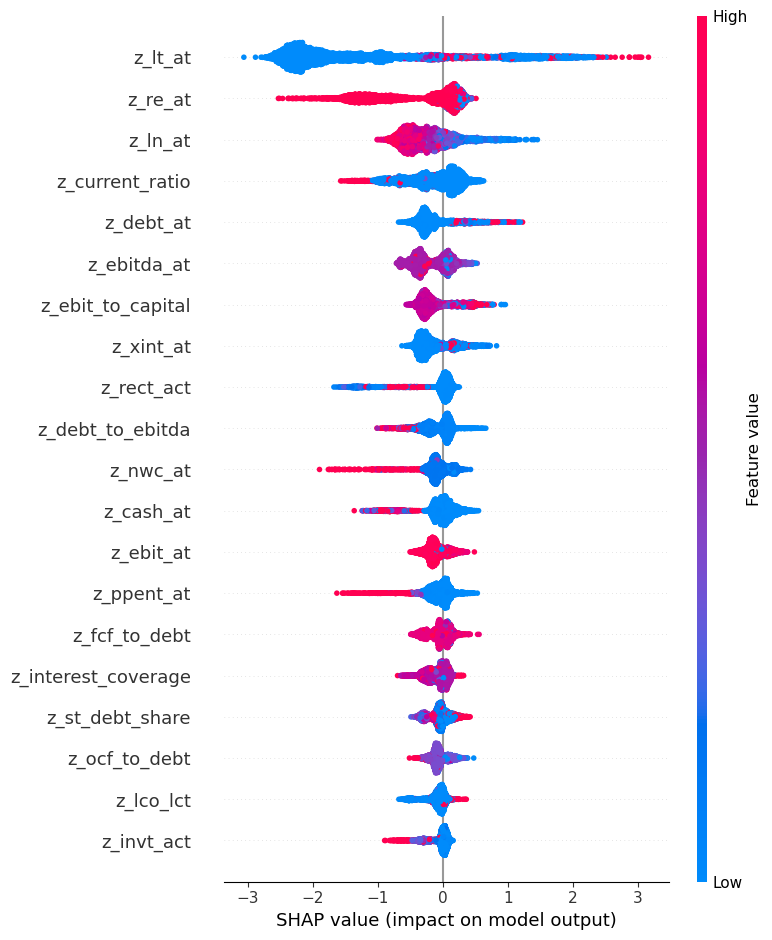

In [43]:
# Gain-based feature importance
importance = xgb_model.get_score(importance_type="gain")
imp_tbl = (pd.DataFrame({"feature": list(importance.keys()), "gain": list(importance.values())})
             .sort_values("gain", ascending=False))
display(imp_tbl.head(20))

# Optional: SHAP summary for a subsample (can be expensive on large panels)
try:
    import shap
    shap.initjs()
    sample_n = min(5000, X_tr.shape[0])
    X_sample = X_tr.sample(sample_n, random_state=SEED)
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_sample)
    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.savefig(Path(CONFIG["FIG_DIR"]) / "shap_summary_tree.png", dpi=160)
    plt.show()
except Exception as e:
    print("SHAP skipped:", e)

## 8. Model Evaluation & Diagnostic Monitoring

All evaluation in this section treats the **test split as untouchable**: no tuning based on test results.

**Clean Evaluation Protocol Note:**
- For **Logit**: The validation (`val`) performance reported below is an honest out-of-sample estimate because it uses a model trained on `train` only. The test performance uses a model trained on `train+val`.
- For **Tree (XGBoost)**: The validation (`val`) performance is **in-sample** relative to early stopping and isotonic calibration, both of which use the validation set. Therefore, `val` performance for trees will appear optimistic.
- **Unbiased Performance**: The **test split** results are the only strictly unbiased final performance metrics.

We report:
- ROC-AUC, PR-AUC, Brier score,
- calibration curve and calibration slope (reliability),
- persistence benchmark,
- collinearity and drift diagnostics.

### 8.1 Out-of-sample metrics (val and test) + persistence benchmark

In [44]:
def eval_metrics(y_true: pd.Series, p: np.ndarray) -> dict:
    y_true = y_true.astype(int).values
    return {
        "roc_auc": roc_auc_score(y_true, p),
        "pr_auc": average_precision_score(y_true, p),
        "brier": brier_score_loss(y_true, p),
        "mean_p": float(np.mean(p)),
        "event_rate": float(np.mean(y_true)),
    }

rows = []
for sp in ["val","test"]:
    mask = df_model["split"] == sp
    y_sp = df_model.loc[mask, TARGET_NAME].astype(int)

    rows.append({"split": sp, "model":"logit", **eval_metrics(y_sp, df_model.loc[mask, "pd_logit"].values)})
    rows.append({"split": sp, "model":"tree_calibrated", **eval_metrics(y_sp, df_model.loc[mask, "pd_tree"].values)})
    rows.append({"split": sp, "model":"tree_raw", **eval_metrics(y_sp, df_model.loc[mask, "pd_tree_raw"].values)})

    # Persistence benchmark: predict next-year distress = current-year PROXY_NAME
    pers = pd.to_numeric(df_model.loc[mask, PROXY_NAME], errors="coerce").fillna(0).astype(int).values
    rows.append({"split": sp, "model":"persistence", **eval_metrics(y_sp, pers)})

metrics_tbl = pd.DataFrame(rows).sort_values(["split","model"])
display(metrics_tbl)

,split,model,roc_auc,pr_auc,brier,mean_p,event_rate
4,test,logit,0.756773,0.429488,0.087759,0.112674,0.121023
7,test,persistence,0.848276,0.604476,0.056828,0.110823,0.121023
5,test,tree_calibrated,0.959598,0.761476,0.046996,0.131226,0.121023
6,test,tree_raw,0.959908,0.773296,0.135335,0.322965,0.121023
0,val,logit,0.785067,0.504983,0.077208,0.108855,0.113658
3,val,persistence,0.829223,0.577720,0.056201,0.097331,0.113658
1,val,tree_calibrated,0.959944,0.764833,0.044419,0.113658,0.113658
2,val,tree_raw,0.958116,0.769327,0.115028,0.292599,0.113658


### 8.1b Early-warning vs Surveillance decomposition (state-conditional evaluation)


In [45]:
# Early-warning vs surveillance evaluation:
#   - Early warning: subset with PROXY_NAME == 0 (not currently distressed)
#   - Surveillance: subset with PROXY_NAME == 1 (currently distressed)
# Also add a state-only baseline: predict next-year distress using current state only.

import numpy as np
import pandas as pd

def safe_eval_metrics(y_true: pd.Series, p: np.ndarray) -> dict:
    y = y_true.astype(int).values
    out = {
        "roc_auc": np.nan,
        "pr_auc": np.nan,
        "brier": brier_score_loss(y, p),
        "mean_p": float(np.mean(p)),
        "event_rate": float(np.mean(y)),
        "n": int(len(y)),
    }
    if np.unique(y).size >= 2:
        out["roc_auc"] = roc_auc_score(y, p)
        out["pr_auc"] = average_precision_score(y, p)
    return out

def eval_segment(df_seg: pd.DataFrame, split_name: str, segment_name: str) -> list:
    rows = []
    if df_seg.empty:
        return rows

    y = df_seg[TARGET_NAME].astype(int)

    # State-only baseline (uses current distress state only)
    state = pd.to_numeric(df_seg[PROXY_NAME], errors="coerce").fillna(0).astype(int).values
    base = safe_eval_metrics(y, state)

    # Models
    for col, mdl in [("pd_logit","logit"),
                     ("pd_tree","tree_calibrated"),
                     ("pd_tree_raw","tree_raw")]:
        met = safe_eval_metrics(y, df_seg[col].values)

        rows.append({
            "split": split_name,
            "segment": segment_name,
            "model": mdl,
            **met,
            "baseline_roc_auc": base["roc_auc"],
            "baseline_pr_auc": base["pr_auc"],
            "baseline_brier": base["brier"],
            "delta_roc_auc": (met["roc_auc"] - base["roc_auc"]) if (met["roc_auc"]==met["roc_auc"] and base["roc_auc"]==base["roc_auc"]) else np.nan,
            "delta_pr_auc": (met["pr_auc"] - base["pr_auc"]) if (met["pr_auc"]==met["pr_auc"] and base["pr_auc"]==base["pr_auc"]) else np.nan,
            "delta_brier": met["brier"] - base["brier"],  # negative is improvement
        })

    # Add baseline as a row for reference
    rows.append({
        "split": split_name,
        "segment": segment_name,
        "model": "state_only",
        **base,
        "baseline_roc_auc": np.nan,
        "baseline_pr_auc": np.nan,
        "baseline_brier": np.nan,
        "delta_roc_auc": 0.0,
        "delta_pr_auc": 0.0,
        "delta_brier": 0.0,
    })
    return rows

seg_rows = []
for sp in ["val", "test"]:
    df_sp = df_model.loc[df_model["split"]==sp, :].copy()

    # Only evaluate segments where current distress state is observed.
    dcur = pd.to_numeric(df_sp[PROXY_NAME], errors="coerce")
    df_sp = df_sp.loc[dcur.notna(), :].copy()
    df_sp["distress_t_int"] = dcur.loc[dcur.notna()].astype(int)

    seg_rows += eval_segment(df_sp.loc[df_sp["distress_t_int"]==0, :], sp, f"early_warning ({PROXY_NAME}=0)")
    seg_rows += eval_segment(df_sp.loc[df_sp["distress_t_int"]==1, :], sp, f"surveillance ({PROXY_NAME}=1)")

seg_metrics_tbl = pd.DataFrame(seg_rows)

if not seg_metrics_tbl.empty:
    seg_metrics_tbl = seg_metrics_tbl.sort_values(["split","segment","model"])
    display(seg_metrics_tbl)
else:
    print("No segment metrics computed (empty segments).")


,split,segment,model,roc_auc,pr_auc,brier,mean_p,event_rate,n,baseline_roc_auc,baseline_pr_auc,baseline_brier,delta_roc_auc,delta_pr_auc,delta_brier
8,test,early_warning (distress_v2_t=0),logit,0.704492,0.097105,0.040801,0.089925,0.037691,10984,0.5,0.037691,0.037691,0.204492,0.059414,0.003109
11,test,early_warning (distress_v2_t=0),state_only,0.500000,0.037691,0.037691,0.000000,0.037691,10984,NaN,NaN,NaN,0.000000,0.000000,0.000000
9,test,early_warning (distress_v2_t=0),tree_calibrated,0.917001,0.300052,0.031215,0.054106,0.037691,10984,0.5,0.037691,0.037691,0.417001,0.262361,-0.006476
10,test,early_warning (distress_v2_t=0),tree_raw,0.917905,0.313857,0.126672,0.241118,0.037691,10984,0.5,0.037691,0.037691,0.417905,0.276166,0.088981
12,test,surveillance (distress_v2_t=1),logit,0.518569,0.817364,0.464526,0.295205,0.789627,1369,0.5,0.789627,0.210373,0.018569,0.027737,0.254154
15,test,surveillance (distress_v2_t=1),state_only,0.500000,0.789627,0.210373,1.000000,0.789627,1369,NaN,NaN,NaN,0.000000,0.000000,0.000000
13,test,surveillance (distress_v2_t=1),tree_calibrated,0.616878,0.846008,0.173607,0.749991,0.789627,1369,0.5,0.789627,0.210373,0.116878,0.056380,-0.036765
14,test,surveillance (distress_v2_t=1),tree_raw,0.616782,0.853028,0.204839,0.979656,0.789627,1369,0.5,0.789627,0.210373,0.116782,0.063401,-0.005533
0,val,early_warning (distress_v2_t=0),logit,0.708335,0.122431,0.040988,0.084609,0.040174,5750,0.5,0.040174,0.040174,0.208335,0.082258,0.000814
3,val,early_warning (distress_v2_t=0),state_only,0.500000,0.040174,0.040174,0.000000,0.040174,5750,NaN,NaN,NaN,0.000000,0.000000,0.000000


### 8.2 Calibration diagnostics (curve + calibration-in-the-large + slope)

val | logit: calibration intercept=0.168, slope=1.059


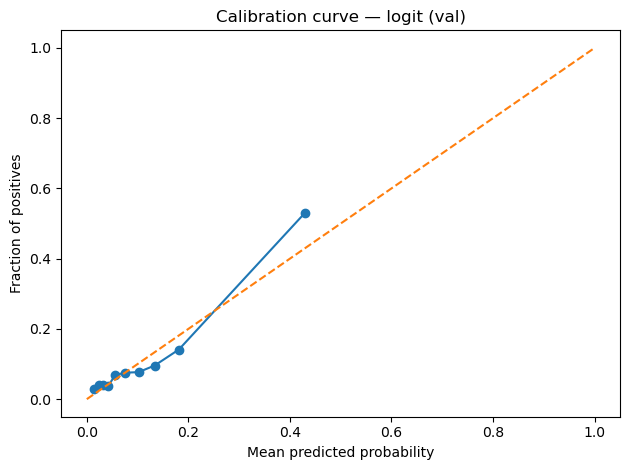

val | tree_calibrated: calibration intercept=0.000, slope=1.000


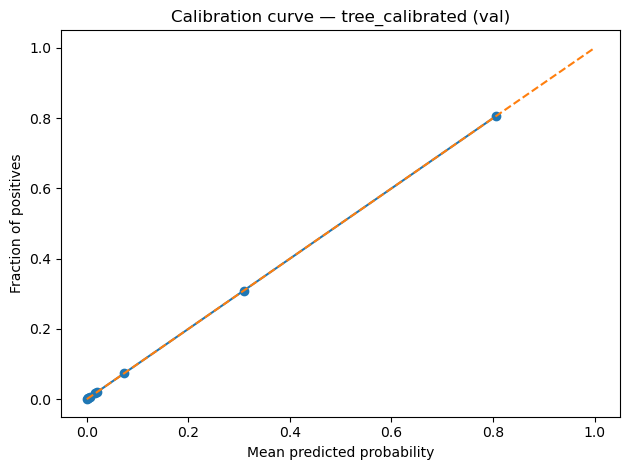

test | logit: calibration intercept=-0.054, slope=0.916


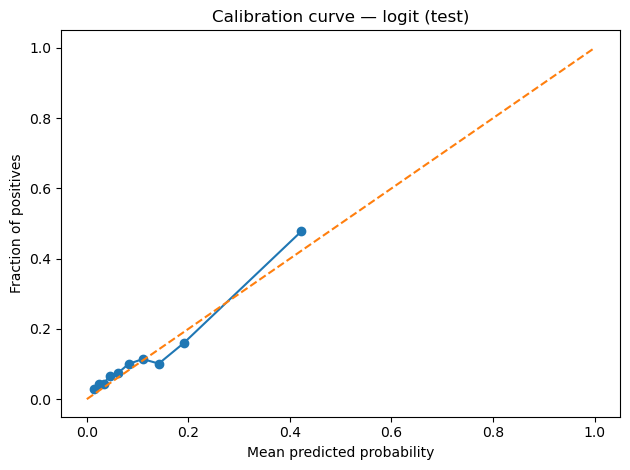

test | tree_calibrated: calibration intercept=-0.188, slope=1.034


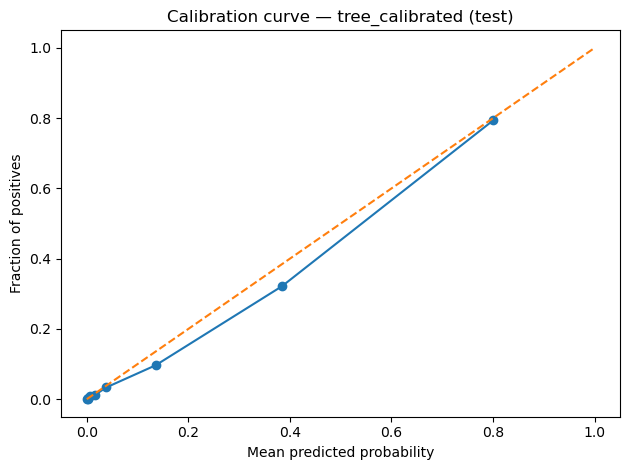

In [46]:
def calibration_slope_intercept(y_true: np.ndarray, p: np.ndarray) -> tuple[float,float]:
    z = logit(p)
    Xc = sm.add_constant(z, has_constant="add")
    mdl = sm.GLM(y_true, Xc, family=sm.families.Binomial())
    res = mdl.fit()
    intercept, slope = res.params[0], res.params[1]
    return float(intercept), float(slope)

def plot_calibration(y_true: np.ndarray, p: np.ndarray, title: str, fname: str):
    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(Path(CONFIG["FIG_DIR"]) / fname, dpi=160)
    plt.show()

for sp in ["val","test"]:
    mask = df_model["split"] == sp
    y_sp = df_model.loc[mask, TARGET_NAME].astype(int).values

    for model_name, pcol in [("logit","pd_logit"), ("tree_calibrated","pd_tree")]:
        p = df_model.loc[mask, pcol].values
        icpt, slope = calibration_slope_intercept(y_sp, p)
        print(f"{sp} | {model_name}: calibration intercept={icpt:.3f}, slope={slope:.3f}")
        plot_calibration(y_sp, p, f"Calibration curve — {model_name} ({sp})", f"cal_curve_{model_name}_{sp}.png")

### 8.3 Temporal stability (walk-forward fold metrics)

,train_years_min,train_years_max,val_year,n_train,n_val,roc_auc,pr_auc,brier
0,2015,2016,2017,13214,6379,0.799623,0.491448,0.081100
1,2015,2017,2018,19593,6253,0.812605,0.534976,0.080961
2,2015,2019,2020,31962,6168,0.777819,0.482912,0.080087
3,2015,2021,2022,44351,6370,0.785067,0.504983,0.077208


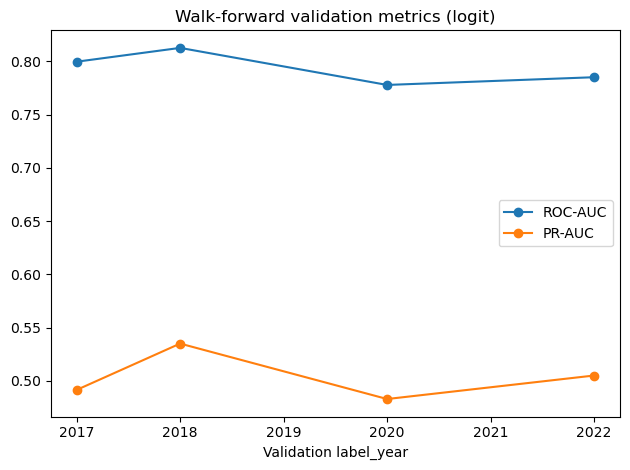

In [47]:
if 'wf_tbl' in globals() and len(wf_tbl) > 0:
    display(wf_tbl)
    plt.figure()
    plt.plot(wf_tbl["val_year"], wf_tbl["roc_auc"], marker="o", label="ROC-AUC")
    plt.plot(wf_tbl["val_year"], wf_tbl["pr_auc"], marker="o", label="PR-AUC")
    plt.title("Walk-forward validation metrics (logit)")
    plt.xlabel("Validation label_year")
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path(CONFIG["FIG_DIR"]) / "walkforward_metrics_logit.png", dpi=160)
    plt.show()

### 8.4 Collinearity checks (VIF + high-correlation pairs)

In [48]:
# VIF on continuous z-features (train only)
X_vif = splits["train"]["X"][[f"z_{c}" for c in continuous_feats_raw]].copy()
X_vif = sm.add_constant(X_vif, has_constant="add")

vif_rows = []
for i, col in enumerate(X_vif.columns):
    if col == "const":
        continue
    vif_rows.append({"feature": col, "VIF": float(variance_inflation_factor(X_vif.values, i))})

vif_tbl = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)
display(vif_tbl)

# Correlation screen (continuous only)
corr = splits["train"]["X"][[f"z_{c}" for c in continuous_feats_raw]].corr()
high_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        v = corr.iloc[i,j]
        if abs(v) >= 0.85:
            high_pairs.append((corr.columns[i], corr.columns[j], float(v)))
high_pairs_tbl = pd.DataFrame(high_pairs, columns=["feat1","feat2","corr"]).sort_values("corr", key=np.abs, ascending=False)
display(high_pairs_tbl)

,feature,VIF
16,z_ebit_at,55.750695
15,z_ebitda_at,53.037524
13,z_debt_at,3.254204
17,z_xint_at,2.819933
12,z_lt_at,2.758336
21,z_ocf_to_debt,2.546052
22,z_fcf_to_debt,2.531342
8,z_ppent_at,2.455462
23,z_capx_at,2.388539
1,z_cash_at,2.287558


,feat1,feat2,corr
0,z_ebitda_at,z_ebit_at,0.983246


### 8.5 Drift diagnostics (standardized mean difference: train vs test)

In [49]:
feat_cols = [f"z_{c}" for c in continuous_feats_raw] + event_feats
drift_rows = []
for c in feat_cols:
    smd = compute_smd(df_model.loc[df_model["split"]=="train", c], df_model.loc[df_model["split"]=="test", c])
    drift_rows.append({"feature": c, "SMD_train_vs_test": smd})
drift_tbl = pd.DataFrame(drift_rows).sort_values("SMD_train_vs_test", key=lambda s: s.abs(), ascending=False)
display(drift_tbl.head(25))

,feature,SMD_train_vs_test
21,z_ocf_to_debt,0.093814
0,z_ln_at,-0.079524
14,z_st_debt_share,-0.062411
23,z_capx_at,0.036258
18,z_interest_coverage,0.034315
11,z_txditc_at,0.031830
22,z_fcf_to_debt,0.030481
17,z_xint_at,0.030313
24,z_re_at,-0.025510
8,z_ppent_at,0.022179


### 8.6 Probability distributions by class (test split)

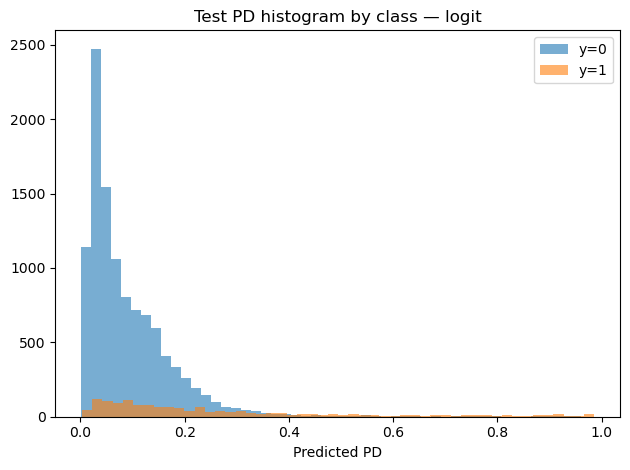

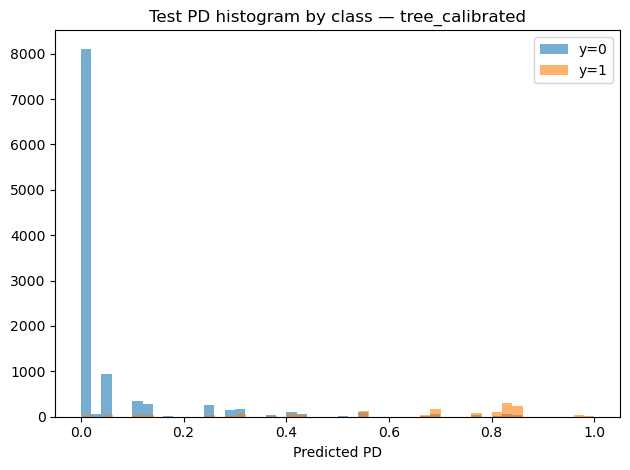

In [50]:
mask = df_model["split"]=="test"
y_true = df_model.loc[mask, TARGET_NAME].astype(int)

for model_name, pcol in [("logit","pd_logit"), ("tree_calibrated","pd_tree")]:
    p = df_model.loc[mask, pcol]
    plt.figure()
    plt.hist(p[y_true==0], bins=50, alpha=0.6, label="y=0")
    plt.hist(p[y_true==1], bins=50, alpha=0.6, label="y=1")
    plt.title(f"Test PD histogram by class — {model_name}")
    plt.xlabel("Predicted PD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path(CONFIG["FIG_DIR"]) / f"pd_hist_{model_name}_test.png", dpi=160)
    plt.show()

## 9. Decision Support Layer

This section operationalizes predicted probabilities into interpretable risk signals and policies:
- **Event lift tables:** how discrete events shift conditional distress risk.
- **Risk deciles:** realized risk by predicted PD decile (reliability in operational tiers).
- **Cost curves & capacity rules:** choose thresholds under explicit misclassification costs and screening capacity.
- **Pro-forma scenarios:** sensitivity of PD to accounting-consistent adjustments (illustrative; not causal).

### 9.1 Event lift tables (prevalence, conditional risk, lift)

In [51]:
def event_lift_table(df_in: pd.DataFrame, events: list[str], y_col: str) -> pd.DataFrame:
    base = df_in[y_col].astype(float).mean()
    rows=[]
    for e in events:
        if e not in df_in.columns:
            continue
        s = pd.to_numeric(df_in[e], errors="coerce").fillna(0).astype(int)
        if s.sum() == 0:
            continue
        rate = df_in.loc[s==1, y_col].astype(float).mean()
        prev = s.mean()
        rows.append({
            "event": e,
            "prevalence": prev,
            "cond_distress_rate": rate,
            "lift_vs_base": rate/base if base>0 else np.nan,
            "base_rate": base,
            "n_event": int(s.sum()),
        })
    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values("lift_vs_base", ascending=False)
    return out

for sp in ["train","test"]:
    df_sp = df_model.loc[df_model["split"]==sp, :]
    print(f"\nEvent lift — {sp}")
    display(event_lift_table(df_sp, event_feats, TARGET_NAME).head(20))


Event lift — train


""



Event lift — test


""


### 9.2 Event transitions (0→1 activation; 1→1 persistence)

In [ ]:
def transition_stats(df_in: pd.DataFrame, event: str) -> dict:
    """Robust transition stats that enforce year adjacency (Issue 1) and handle NaNs (Issue 2)."""
    s = pd.to_numeric(df_in[event], errors="coerce")
    s_l1 = lag(df_in, event, 1)
    
    # Valid transitions require both observed and adjacent years
    valid = s.notna() & s_l1.notna()
    s_valid = s[valid].astype(int)
    s_l1_valid = s_l1[valid].astype(int)
    
    if len(s_valid) == 0:
         return {"event": event, "activation_01_rate": np.nan, "persistence_11_rate": np.nan}

    act_01 = ((s_l1_valid==0) & (s_valid==1)).mean()
    pers_11 = ((s_l1_valid==1) & (s_valid==1)).mean()
    return {"event": event, "activation_01_rate": float(act_01), "persistence_11_rate": float(pers_11)}

rows=[]
for e in event_feats:
    rows.append(transition_stats(df_model, e))
trans_tbl = pd.DataFrame(rows)
if not trans_tbl.empty:
    trans_tbl = trans_tbl.sort_values("activation_01_rate", ascending=False)
display(trans_tbl)

### 9.3 Risk deciles (expected vs realized distress by PD tier)

In [ ]:
def decile_table(df_in: pd.DataFrame, p_col: str, y_col: str) -> pd.DataFrame:
    d = df_in[[p_col, y_col]].dropna().copy()
    d["decile"] = pd.qcut(d[p_col], 10, labels=False, duplicates="drop") + 1
    out = d.groupby("decile").agg(
        n=("decile","size"),
        mean_pd=(p_col,"mean"),
        realized_rate=(y_col,"mean"),
    ).reset_index()
    out["calibration_gap"] = out["realized_rate"] - out["mean_pd"]
    return out

for model_name, pcol in [("logit","pd_logit"), ("tree_calibrated","pd_tree")]:
    print(f"\nTest deciles — {model_name}")
    dt = decile_table(df_model.loc[df_model["split"]=="test", :], pcol, TARGET_NAME)
    display(dt)

### 9.4 Cost curves and threshold selection (validation-only)

In [ ]:
COST_FN = float(CONFIG["COST_FN"])
COST_FP = float(CONFIG["COST_FP"])
CAPACITY_PCT = float(CONFIG["CAPACITY_PCT"])

def expected_cost(y_true: np.ndarray, p: np.ndarray, thr: float) -> float:
    y_hat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    return COST_FN*fn + COST_FP*fp

def cost_curve(y_true: np.ndarray, p: np.ndarray, grid: np.ndarray) -> pd.DataFrame:
    rows=[]
    for thr in grid:
        y_hat = (p >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({
            "thr": float(thr),
            "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
            "cost": float(COST_FN*fn + COST_FP*fp),
            "tpr": float(tp/(tp+fn)) if (tp+fn)>0 else np.nan,
            "fpr": float(fp/(fp+tn)) if (fp+tn)>0 else np.nan,
        })
    return pd.DataFrame(rows)

grid = np.linspace(0.01, 0.99, 99)

mask = df_model["split"]=="val"
y_val_np = df_model.loc[mask, TARGET_NAME].astype(int).values

thr_tbls = {}
for model_name, pcol in [("logit","pd_logit"), ("tree_calibrated","pd_tree")]:
    p = df_model.loc[mask, pcol].values
    cc = cost_curve(y_val_np, p, grid)
    thr_star = float(cc.loc[cc["cost"].idxmin(), "thr"])
    thr_capacity = float(np.quantile(p, 1-CAPACITY_PCT))
    thr_tbls[model_name] = {"thr_cost_opt": thr_star, "thr_capacity": thr_capacity}

    plt.figure()
    plt.plot(cc["thr"], cc["cost"])
    plt.title(f"Validation expected cost vs threshold — {model_name}")
    plt.xlabel("Threshold")
    plt.ylabel("Expected misclassification cost")
    plt.tight_layout()
    plt.savefig(Path(CONFIG["FIG_DIR"]) / f"cost_curve_{model_name}_val.png", dpi=160)
    plt.show()

    print(model_name, "cost-opt thr=", thr_star, "capacity thr=", thr_capacity)

display(pd.DataFrame(thr_tbls).T)

### 9.5 Decision curve analysis (net benefit)

In [ ]:
def net_benefit(y_true: np.ndarray, p: np.ndarray, pt: float) -> float:
    y_hat = (p >= pt).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    n = len(y_true)
    w = pt/(1-pt)
    return (tp/n) - (fp/n)*w

mask = df_model["split"]=="test"
y_test_np = df_model.loc[mask, TARGET_NAME].astype(int).values

pts = np.linspace(0.01, 0.50, 50)
plt.figure()
for model_name, pcol in [("logit","pd_logit"), ("tree_calibrated","pd_tree")]:
    p = df_model.loc[mask, pcol].values
    nb = [net_benefit(y_test_np, p, pt) for pt in pts]
    plt.plot(pts, nb, label=model_name)

# Treat-all and treat-none baselines
event_rate = y_test_np.mean()
nb_all = [event_rate - (1-event_rate)*(pt/(1-pt)) for pt in pts]
nb_none = [0 for _ in pts]
plt.plot(pts, nb_all, linestyle="--", label="treat-all")
plt.plot(pts, nb_none, linestyle="--", label="treat-none")

plt.title("Decision curves (test split): net benefit vs threshold probability")
plt.xlabel("Threshold probability (pt)")
plt.ylabel("Net benefit")
plt.legend()
plt.tight_layout()
plt.savefig(Path(CONFIG["FIG_DIR"]) / "decision_curves_test.png", dpi=160)
plt.show()

### 9.6 Scenario analysis (accounting-consistent pro-forma adjustments; illustrative)

In [ ]:
# Scenario engine: recompute a single-row feature vector using the same rules as the main pipeline.

def build_model_features_from_row(row: pd.Series) -> pd.DataFrame:
    # --- Helper for safe ratios in single row ---
    def safe_div(n, d):
        try:
            n_f = float(n)
            d_f = float(d)
            if pd.isna(n_f) or pd.isna(d_f) or d_f == 0:
                return np.nan
            return n_f / d_f
        except:
            return np.nan

    # Raw items from row
    at = row.get("at", np.nan)
    che = row.get("che", np.nan)
    act = row.get("act", np.nan)
    lct = row.get("lct", np.nan)
    aco = row.get("aco", np.nan)
    lco = row.get("lco", np.nan)
    rect = row.get("rect", np.nan)
    invt = row.get("invt", np.nan)
    recch = row.get("recch", np.nan)
    invch = row.get("invch", np.nan)
    txp = row.get("txp", np.nan)
    txditc = row.get("txditc", np.nan)
    lt = row.get("lt", np.nan)
    dlc = row.get("dlc", np.nan)
    dltt = row.get("dltt", np.nan)
    oibdp = row.get("oibdp", np.nan)
    dp = row.get("dp", np.nan)
    xint = row.get("xint", np.nan)
    ceq = row.get("ceq", np.nan)
    capx = row.get("capx", np.nan)
    ppent = row.get("ppent", np.nan)
    intan = row.get("intan", np.nan)
    oancf = row.get("oancf", np.nan)
    re = row.get("re", np.nan)
    caps = row.get("caps", np.nan)
    mibt = row.get("mibt", np.nan)
    niadj = row.get("niadj", np.nan)
    aqc = row.get("aqc", np.nan)
    prstkc = row.get("prstkc", np.nan)

    # Debt aggregate matching df logic
    d_vals = [v for v in [dlc, dltt] if pd.notna(v)]
    total_debt = sum(d_vals) if d_vals else np.nan

    # Map of all potential continuous features
    feat_map = {}
    feat_map["ln_at"] = np.log(at) if pd.notna(at) and at > 0 else np.nan
    feat_map["cash_at"] = safe_div(che, at)
    feat_map["current_ratio"] = safe_div(act, lct)
    feat_map["nwc_at"] = safe_div(act - lct, at)
    feat_map["aco_act"] = safe_div(aco, act)
    feat_map["lco_lct"] = safe_div(lco, lct)
    feat_map["rect_act"] = safe_div(rect, act)
    feat_map["invt_act"] = safe_div(invt, act)
    feat_map["recch_act"] = safe_div(recch, act)
    feat_map["invch_act"] = safe_div(invch, act)
    feat_map["txp_lct"] = safe_div(txp, lct)
    feat_map["txditc_at"] = safe_div(txditc, at)
    feat_map["lt_at"] = safe_div(lt, at)
    feat_map["dlc_at"] = safe_div(dlc, at)
    feat_map["dltt_at"] = safe_div(dltt, at)
    feat_map["debt_at"] = safe_div(total_debt, at)
    feat_map["st_debt_share"] = safe_div(dlc, total_debt)
    feat_map["ebitda_at"] = safe_div(oibdp, at)
    feat_map["ebit_at"] = safe_div(oibdp - dp, at)
    feat_map["dp_at"] = safe_div(dp, at)
    feat_map["xint_at"] = safe_div(xint, at)
    feat_map["interest_coverage"] = safe_div(oibdp, xint)
    feat_map["debt_to_ebitda"] = safe_div(total_debt, oibdp)
    feat_map["ebit_to_capital"] = safe_div(oibdp - dp, total_debt + ceq)
    feat_map["capx_at"] = safe_div(capx, at)
    
    # V2 extras
    feat_map["ppent_at"] = safe_div(ppent, at)
    feat_map["intan_at"] = safe_div(intan, at)
    feat_map["ocf_to_debt"] = safe_div(oancf, total_debt)
    feat_map["fcf_to_debt"] = safe_div(oancf - capx, total_debt)
    feat_map["re_at"] = safe_div(re, at)
    
    # V3 extras
    feat_map["ceq_at"] = safe_div(ceq, at)
    feat_map["caps_at"] = safe_div(caps, at)
    feat_map["mibt_at"] = safe_div(mibt, at)
    feat_map["niadj_at"] = safe_div(niadj, at)
    feat_map["xint_lct"] = safe_div(xint, lct)
    feat_map["aqc_at"] = safe_div(aqc, at)
    feat_map["prstkc_at"] = safe_div(prstkc, at)

    # Event map
    event_map = {}
    event_map["loss_indicator"] = 1.0 if pd.notna(niadj) and niadj < 0 else 0.0

    # Assemble raw feature vector
    out_dict = {}
    for c in continuous_feats_raw:
        out_dict[c] = feat_map.get(c, np.nan)
    for e in event_feats:
        out_dict[e] = event_map.get(e, 0)
    
    out = pd.DataFrame([out_dict])

    # Preprocessing: train medians, winsor, scaler -> z_
    for c in continuous_feats_raw:
        v = out[c].replace([np.inf, -np.inf], np.nan)
        v = v.fillna(train_medians[c])
        lo, hi = winsor_bounds[c]
        v = apply_bounds(v, lo, hi)
        out[c] = v

    Z = scaler.transform(out[continuous_feats_raw].astype(float))
    for j, c in enumerate(continuous_feats_raw):
        out[f"z_{c}"] = Z[:, j]

    # Final feature vector in MODEL_FEATS order
    return out[[f"z_{c}" for c in continuous_feats_raw] + event_feats]

def predict_pd_from_features(X_row: pd.DataFrame) -> dict:
    pd_logit = float(logit_clf.predict_proba(X_row)[:, 1][0])
    drow = xgb.DMatrix(X_row, feature_names=X_row.columns.tolist())
    pd_tree_raw = float(xgb_model.predict(drow)[0])
    pd_tree = float(iso.transform([pd_tree_raw])[0])
    return {"pd_logit": pd_logit, "pd_tree": pd_tree, "pd_tree_raw": pd_tree_raw}

# Select a representative high-risk test observation
test_df = df_model.loc[df_model["split"]=="test", :].copy()
rep_idx = test_df["pd_logit"].idxmax()
row0 = df.loc[rep_idx, :]  # use df (feature-engineered, imputed), not df_model
base_X = build_model_features_from_row(row0)
base_pd = predict_pd_from_features(base_X)

print("Representative observation (highest logit PD in test):")
display(df_model.loc[rep_idx, ["firm_id","fyear","label_year","pd_logit","pd_tree","target_next_v1","target_next_v2","target_next_v3"]])
print("Base PDs:", base_pd)

# Scenario 1: Liquidity buffer to current ratio = 1.2 (increase current assets; illustrative)
row1 = row0.copy()
if "act" in row1.index and "lct" in row1.index and pd.notna(row1["act"]) and pd.notna(row1["lct"]) and row1["lct"] > 0:
    target_cr = 1.2
    add_act = max(0.0, target_cr*row1["lct"] - row1["act"])
    row1["act"] = row1["act"] + add_act
    if "che" in row1.index and pd.notna(row1.get("che", np.nan)):
        row1["che"] = row1["che"] + add_act  # assume added liquidity goes to cash
X1 = build_model_features_from_row(row1)
pd1 = predict_pd_from_features(X1)

# Scenario 2: CFO improvement of +10% of assets (accounting-consistent in the short-run is debatable; treat as stress-test)
row2 = row0.copy()
if "oancf" in row2.index and "at" in row2.index and pd.notna(row2["at"]):
    delta = 0.10 * row2["at"]
    row2["oancf"] = (row2["oancf"] if pd.notna(row2.get("oancf", np.nan)) else 0.0) + delta
X2 = build_model_features_from_row(row2)
pd2 = predict_pd_from_features(X2)

scenario_tbl = pd.DataFrame([
    {"scenario":"base", **base_pd},
    {"scenario":"liquidity_buffer_CR_1.2", **pd1},
    {"scenario":"CFO_plus_10pct_assets", **pd2},
])
display(scenario_tbl)

## 10. Results Summary & Interpretation Guardrails

### 10.1 Interpretation guardrails (publication-ready language)

- The label is a **constructed proxy** for balance-sheet/coverage stress; it is not a legal default outcome.
- Coefficients and SHAP values are **associational and predictive**, not causal effects.
- Even with leakage controls, residual mechanical endogeneity may remain because accounting choices jointly affect both predictors and the proxy label.
- Attrition (missing next-year observations) can create sample-selection distortions; diagnostics are reported via `has_next_year_obs`.

### 10.2 Replication artifacts

The following tables/exports are written to `outputs/` for downstream paper workflow:
- `config_summary.json`
- `distress_rule.json`
- `event_dictionary.csv`
- `logit_inference_table.csv`
- `metrics_table.csv`
- `predictions.csv`

### 10.3 Export tables, thresholds, and predictions

In [ ]:
out_dir = Path(CONFIG["OUTPUT_DIR"])

# Config + distress rule
(out_dir / "config_summary.json").write_text(json.dumps(CONFIG, indent=2))
(out_dir / "distress_rule.json").write_text(json.dumps(DISTRESS_RULE, indent=2))

# Event dictionary
event_dict.to_csv(out_dir / "event_dictionary.csv", index=False)

# Logit inference table
infer_tbl.reset_index().to_csv(out_dir / "logit_inference_table.csv", index=False)

# Metrics table
metrics_tbl.to_csv(out_dir / "metrics_table.csv", index=False)

# Predictions export (replication-friendly)
export_cols = ["firm_id","gvkey","fyear","label_year","split","target_next_v1","target_next_v2","target_next_v3","pd_logit","pd_tree"]
export_cols = [c for c in export_cols if c in df_model.columns]
export_cols += [c for c in event_feats if c in df_model.columns]
pred_export = df_model[export_cols].copy()
pred_export.to_csv(out_dir / "predictions.csv", index=False)

print("Wrote artifacts to:", out_dir.resolve())
print_df(pred_export, n=10, name="predictions.csv preview")

### 10.4 Deployment and maintenance (future work)

This notebook produces a research-grade replication pipeline. For production use (not required for journal replication), a minimal MLOps extension would include:
- scheduled re-scoring and monitoring for drift in feature distributions and target prevalence,
- retraining triggers and versioned model registry,
- data validation contracts (schema + unit tests) for the upstream Compustat extraction process.